In [1]:
#load libraries and setup file
import sys,os
root_path = os.path.abspath(os.path.join('..'))
print(root_path)
if root_path not in sys.path:
    sys.path.append(root_path)
%run -i "../lib/utils/ipynb_setup.py"
%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/max/Dropbox/scripts/Projects/decisionmaking/code/oppcosts


In [3]:
#plotting
import matplotlib.pyplot as pl
import seaborn as sns
sns.set_style("ticks", {'axes.grid' : True})
pl.rc("figure", facecolor="white",figsize = (8,8))
#pl.rc("figure", facecolor="gray",figsize = (8,8))
pl.rc('text', usetex=True)
pl.rc('text.latex', preamble=[r'\usepackage{amsmath}'])
pl.rc('lines',markeredgewidth = 2)
pl.rc('font',size = 12)

In [125]:
#check these are consistent with dyn_prog_model.npy
para=dict()
para['T']=15
para['T_ITI']=7.5#para['T']/2=7.5 in primate experiments set to 8 so that all trial durations are integers
para['p']=1/2
para['tp']=0
alp_slow=1/4
alp_fast=3/4

## Load and plot Monkey occupancy and decision times

In [4]:
import scipy.io as spio
mat = spio.loadmat('../data/toktrials.mat', squeeze_me=True)

In [5]:
mat['toktrials'].flatten().dtype

dtype([('idSubject', 'O'), ('nPostInterval', 'O'), ('nChoiceMade', 'O'), ('nCorrectChoice', 'O'), ('tDecision', 'O'), ('tFirstTokJump', 'O'), ('nDecisionToken', 'O'), ('nDProb', 'O'), ('nDSLR', 'O'), ('sTokenDirs', 'O'), ('sTrialType', 'O')])

x       68746
M       61372
null    33965
E       29380
A       15771
Name: sTrialType, dtype: int64

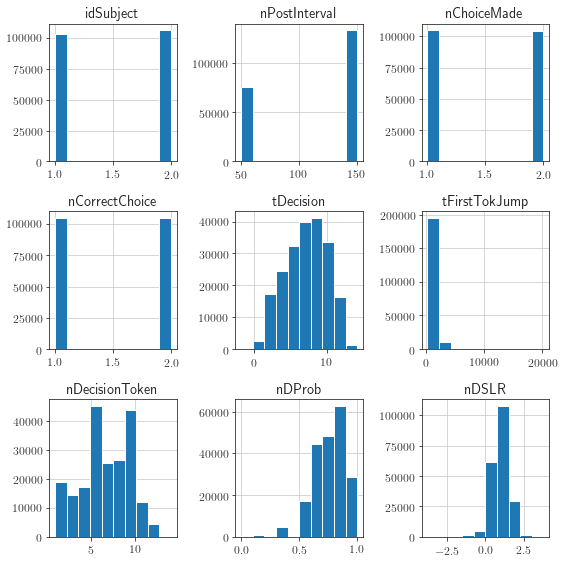

In [6]:
col_names=mat['toktrials'].flatten().dtype.names
df_data=pd.DataFrame(columns=col_names)
for col_name in col_names:
    df_data[col_name]=mat['toktrials'].flatten()[0][col_name]

#prune and reindex:
#-redefine decision time in jump units
df_data.tDecision=(df_data.tDecision-df_data.tFirstTokJump)/200+1 #since first jump at t=1
#-remove samples with null deicsion times 
df_data=df_data[~df_data.tDecision.isnull()]
#-remove hand designed trials 
df_data=df_data[~(df_data.sTrialType.isin(df_data.sTrialType.unique()[-2:]) & (df_data.sTrialType.isin(df_data.sTrialType.unique()[-2:])))]
df_data.reset_index()

#plot
df_data.head()
df_data.hist()
pl.tight_layout()
df_data.sTrialType.value_counts()
#sTrialType :A string describing the trial type: 
# easy (‘E’), 
# ambiguous (‘A’), 
# misleading (‘M’), 
# bias-for (‘C’ or ‘c’), 
# random (‘x’), or 
# unclassified (‘null’)


Monkey performance

In [6]:
block_times=[150,50]
T_ITI=7.5 #1500 ms with 200ms steps
T=15
for mon in range(1,3):
    for post_interval in block_times:
        mon_trials=(df_data.idSubject==mon)
        block_trials=(df_data.nPostInterval==post_interval)
        accuracy=(df_data[mon_trials & block_trials].nCorrectChoice==df_data[mon_trials & block_trials].nChoiceMade).sum()/len(df_data[mon_trials & block_trials])
        avg_trial_duration=(df_data[mon_trials & block_trials].tDecision.values+(post_interval/200.)*(T-df_data[mon_trials & block_trials].tDecision.values)+T_ITI).mean()
        reward_rate=accuracy/avg_trial_duration
        print(str(mon)+' '+str(post_interval)+' '+str((mon_trials & block_trials).sum())+' '+str(accuracy)+' '+str(avg_trial_duration)+' '+str(reward_rate))

1 150 66897 0.7899158407701392 20.77996167615887 0.03801334444598232
1 50 36274 0.7449412802558306 15.94427065529029 0.046721565154105055
2 150 66654 0.7646802892549585 20.66981529615627 0.0369950228533081
2 50 39409 0.7094064807531275 15.210405554568752 0.046639550681805655


unique trajectories in sample

In [7]:
uni_trajs=df_data.sTokenDirs.nunique()
tot_trajs=np.power(2,15)
print(str(tot_trajs)+'(tot) -'+str(uni_trajs)+'(unis) = '+str(tot_trajs-uni_trajs)+' missing')

32768(tot) -32392(unis) = 376 missing


map to +/-1

In [7]:
df_data.nCorrectChoice=2*(df_data.nCorrectChoice.values.astype('int')-1)-1 #assuming 1=False, 2=True
df_data.nChoiceMade=2*(df_data.nChoiceMade.values.astype('int')-1)-1 #assuming 1=False, 2=True

response time distributions over trials

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ae9d1bbe0>,
      dtype=object)

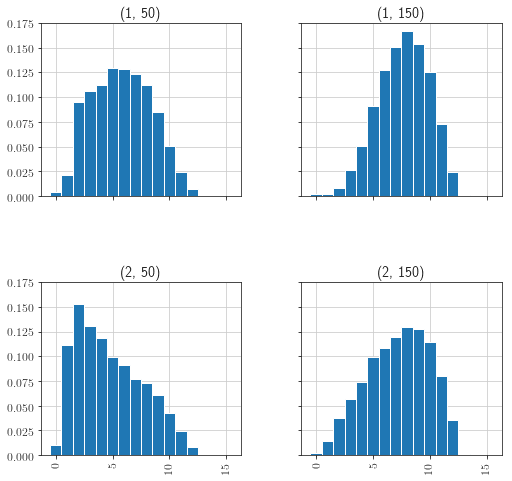

In [9]:
df_data.tDecision.astype('int').hist(by=[df_data['idSubject'],df_data['nPostInterval']],bins=np.arange(17)-0.5,density=True,sharey=True,sharex=True)

slight sinusoidal oscillation in response timing between token jumps in monkey 1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ae9d0e048>,
      dtype=object)

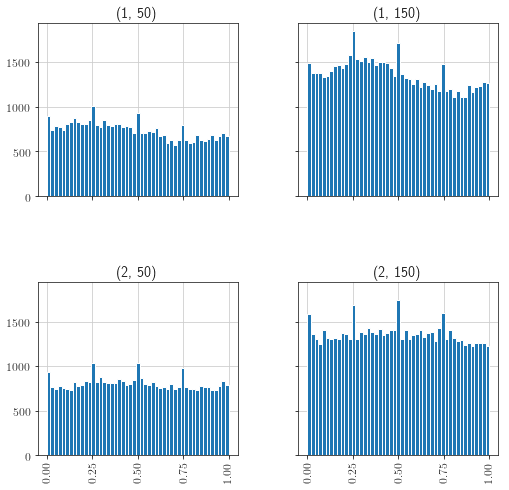

In [10]:
(df_data.tDecision-df_data.tDecision.astype('int')).hist(by=[df_data['idSubject'],df_data['nPostInterval']],bins=np.linspace(0,1,50),sharey=True,sharex=True)

In [8]:
from lib.lib import get_trajs,get_pt_plus

In [9]:
df_data['seq']=df_data.sTokenDirs.apply(lambda x:2*(np.asarray([int(el) for el in list(x)])-1)-1) #note indexing starts at t=1, since len=T not T+1

In [10]:
df_data['Nt']=df_data.seq.apply(lambda x: np.insert(np.cumsum(x),0,0))
def dummy(row):
    return np.array([get_pt_plus(t,Nt) for t,Nt in enumerate(row)])
df_data['Pt_plus']=df_data.Nt.apply(lambda x: dummy(x))

In [11]:
df_data['pcorratDectime']=df_data.apply(lambda row:np.max([row.Pt_plus[int(row.tDecision)],1-row.Pt_plus[int(row.tDecision)]]),axis=1) 


## Look at temporal evolution of learning (though this is already a learned state)

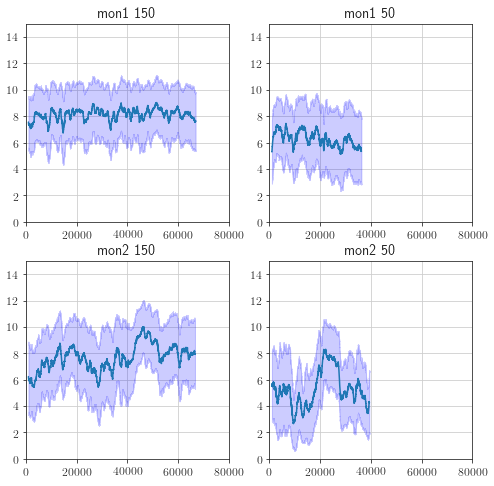

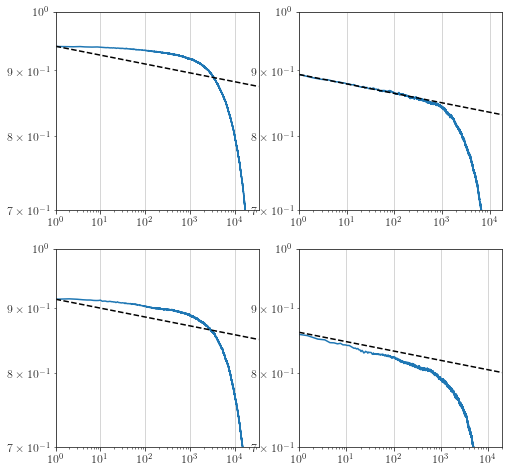

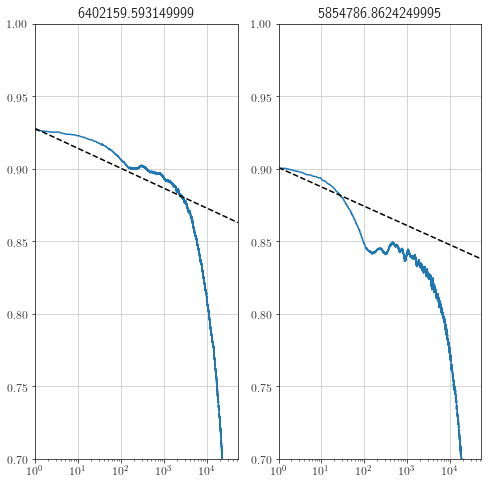

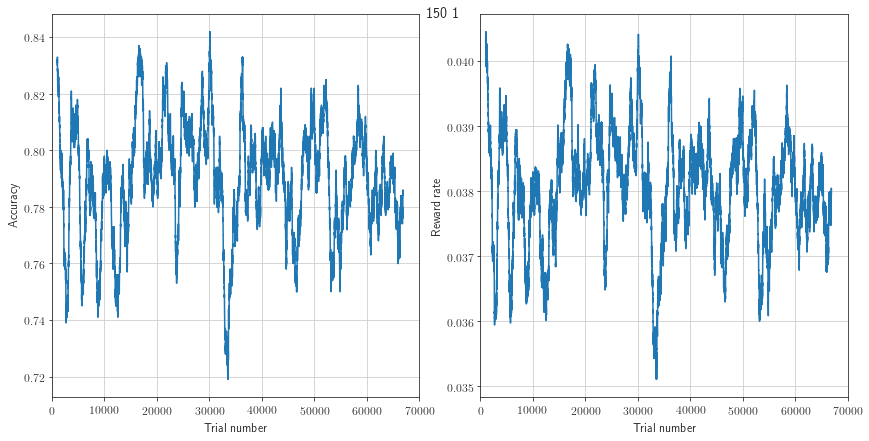

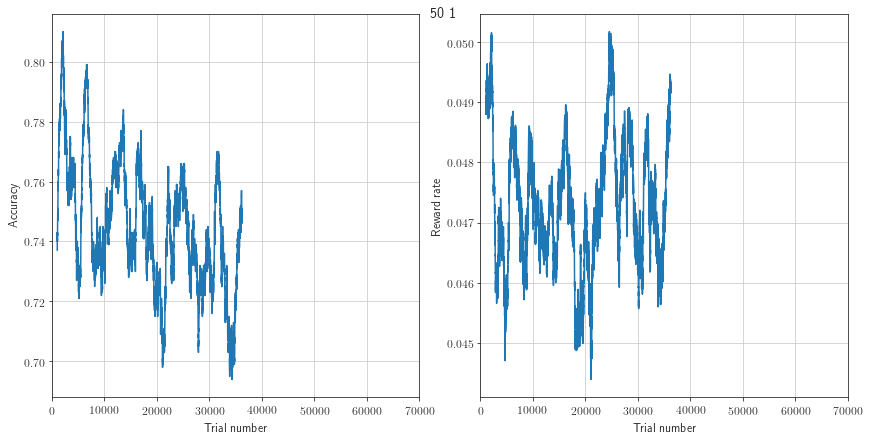

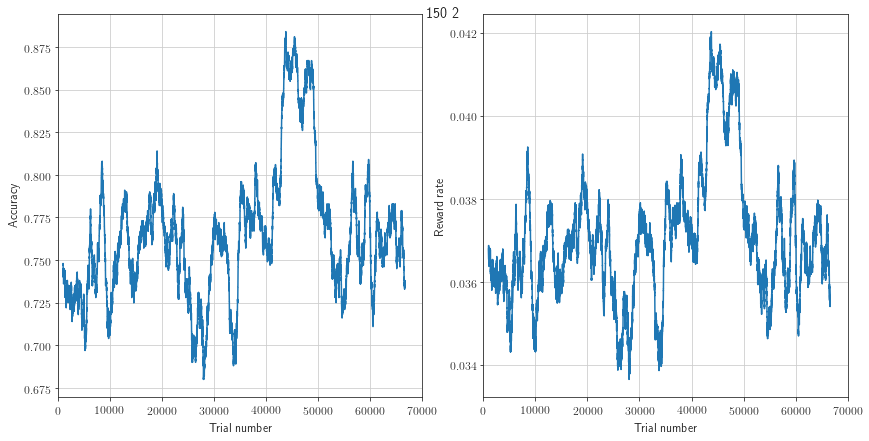

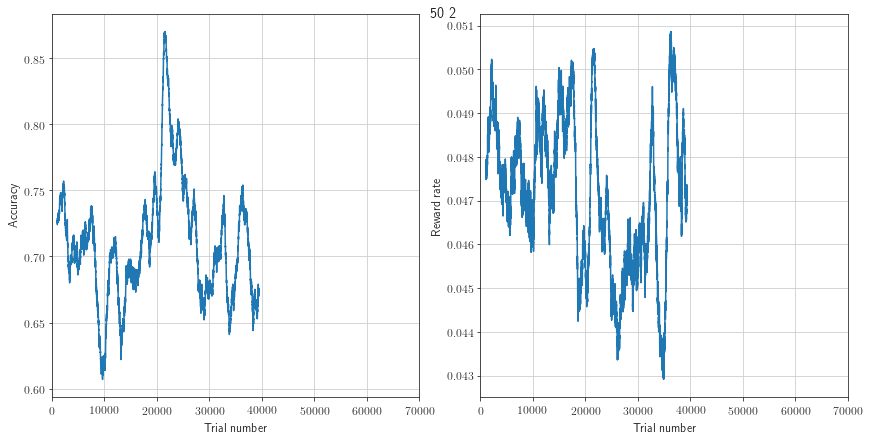

In [153]:
# win_size_vec=[1,500,1000,2000]
# for win_size in win_size_vec:
win_size=1000
NPOINTS=40454
color_res=int(NPOINTS/win_size)
COLOR='blue'
RESFACT=10
MAP='winter'
cm = pl.get_cmap(MAP)

# num_blocks=32
num_blocks=8

block_times=[150,50]
gamvec=[3/4,1/4]
fig,ax=pl.subplots(2,2)
fig3,ax3=pl.subplots(2,2)
fig4,ax4=pl.subplots(1,2)
for i in range(1,3):
    data_check=[]
#     fig3,ax3=pl.subplots(1,1,figsize=(6,6))

    df_tmp=df_data.loc[(df_data.idSubject==i)].reset_index()
    auto_corr=np.correlate(df_tmp.tDecision.values, df_tmp.tDecision.values, mode='same')
    variance=auto_corr[int(len(auto_corr)/2)]
    normed_ac=auto_corr/variance
    ax4[i-1].plot(np.arange(-len(auto_corr)/2,len(auto_corr)/2),normed_ac)
    ax4[i-1].set_xlim(1,len(auto_corr)/2)
#     ax4[i-1].set_xlim(1,1000)
    ax4[i-1].set_xscale('log')
#     ax4[i-1].set_yscale('log')
    ax4[i-1].set_ylim(0.7,1)
    ax4[i-1].plot([1, int(len(auto_corr)/2)],[normed_ac[int(len(auto_corr)/2)+1],normed_ac[int(len(auto_corr)/2)+1]*0.93],'k--')
    ax4[i-1].set_title(str(variance))
    for j,post_interval in enumerate(block_times):
        df_tmp=df_data.loc[((df_data.idSubject==i) & (df_data.nPostInterval==post_interval))].reset_index()
#         df_tmp=df_data.loc[df_data.idSubject==i].reset_index()

        me=df_tmp.tDecision.rolling(window=win_size).mean()
        std=df_tmp.tDecision.rolling(window=win_size).std()
        maxval=df_tmp.tDecision.rolling(window=win_size).max()
        minval=df_tmp.tDecision.rolling(window=win_size).min()

        ax[i-1,j].fill_between(range(len(me)), me - std, me + std,color='b', alpha=0.2)
        df_tmp.tDecision.rolling(window=win_size).mean().plot.line(ax=ax[i-1,j])
        ax[i-1,j].set_ylim(0,para['T'])
        ax[i-1,j].set_xlim(0,80000)
        ax[i-1,j].set_title('mon'+str(i)+' '+str(post_interval))

        df_tmp['reward']=(df_tmp.nChoiceMade==df_tmp.nCorrectChoice)
        df_tmp['reward_rate']=df_tmp['reward']/(df_tmp.tDecision+df_tmp.nPostInterval/200*(para['T']-df_tmp.tDecision)+7.5)

        fig2,ax2=pl.subplots(1,2,figsize=(12,6))
        df_tmp.reward.rolling(window=win_size).mean().plot.line(ax=ax2[0])
        df_tmp.reward_rate.rolling(window=win_size).mean().plot.line(ax=ax2[1])
        ax2[1].set_xlim(0,70000)
        ax2[0].set_xlim(0,70000)
        fig2.tight_layout()
        fig2.suptitle(str(post_interval)+' '+str(i))

        ax2[0].set_ylabel('Accuracy')
        ax2[1].set_ylabel('Reward rate')
        ax2[0].set_xlabel('Trial number')
        ax2[1].set_xlabel('Trial number')
        
        auto_corr=np.correlate(df_tmp.tDecision.values, df_tmp.tDecision.values, mode='same')
        normed_ac=auto_corr/auto_corr[int(len(auto_corr)/2)]
        ax3[i-1,j].plot(np.arange(-len(auto_corr)/2,len(auto_corr)/2),normed_ac)
        ax3[i-1,j].set_xlim(1,len(auto_corr)/2)
        ax3[i-1,j].set_xscale('log')
        ax3[i-1,j].set_yscale('log')
        ax3[i-1,j].set_ylim(0.7,1)
        ax3[i-1,j].plot([1, int(len(auto_corr)/2)],[normed_ac[int(len(auto_corr)/2)+1],normed_ac[int(len(auto_corr)/2)+1]*0.93],'k--')
fig.savefig('long_data.pdf', transparent=True,bbox_inches="tight",dpi=300)
# #         data_check.append(df_tmp.reward_rate.rolling(window=win_size).mean().values)
#         data_check.append(df_tmp.groupby('block_ind').reward_rate.mean().rolling(window=num_blocks).mean().values)
        

# #     ax3.set_xlim(0,70000)
#     ax3.set_prop_cycle('color',[cm(1.*i/(len(data_check[1])-1)) for i in range(len(data_check[1])-1)])
# #     ax3.set_prop_cycle('color',[cm(1.*i/(color_res-1)) for i in range(color_res-1)])
#     x=data_check[0][:len(data_check[1])]
#     y=data_check[1]
# #     for i in range(color_res-5):
# #         ax3.plot(x[win_size*i:win_size*(i+1)],y[win_size*i:win_size*(i+1)])
# #         ax3.plot([x[win_size*i]],[y[win_size*i]],'ko')
# #         ax3.plot(x[color_res*i:color_res*(i+1)],y[color_res*i:color_res*(i+1)])
#     for i in range(len(data_check[1])):
#         ax3.plot(x[i:(i+2)],y[i:(i+2)],'.-')
    
# #     ax3.plot(data_check[0][:len(data_check[1])],data_check[1],'.')
#     fig3.suptitle(str(i))

#     ax3.set_ylabel('Reward rate slow')
#     ax3.set_xlabel('Reward rate fast')
# #         ax2[1].plot(ax2[1].get_xlim(),[(1/2)/(T/4+7.5)]*2,'k--')

6.259027540387054
8.119846704635483
5.280540739425004
7.679261184625078


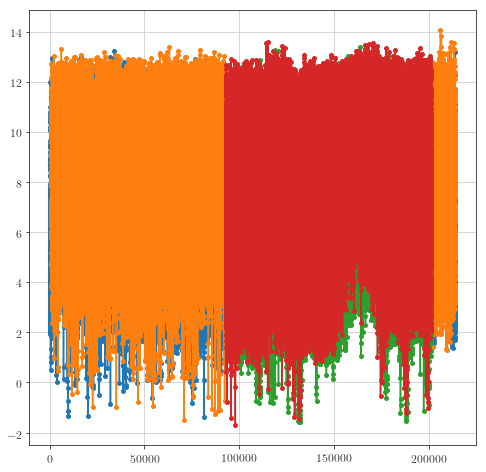

In [36]:
fig,ax=pl.subplots()
for mon in [1,2]:
    # df_data.loc[df_data.idSubject==mon,'nPostInterval'].plot(ax=ax,linestyle='-',marker='o')
    df_data.loc[(df_data.idSubject==mon) & (df_data.nPostInterval==50),'tDecision'].plot(ax=ax,linestyle='-',marker='.')
    print(df_data.loc[(df_data.idSubject==mon) & (df_data.nPostInterval==50),'tDecision'].mean())
    # ax.set_xlim(90000,110000)
    df_data.loc[(df_data.idSubject==mon) & (df_data.nPostInterval==150),'tDecision'].plot(ax=ax,linestyle='-',marker='.')
    print(df_data.loc[(df_data.idSubject==mon) & (df_data.nPostInterval==150),'tDecision'].mean())

## Block size analysis

Text(0.5, 0, 'block duration (trials)')

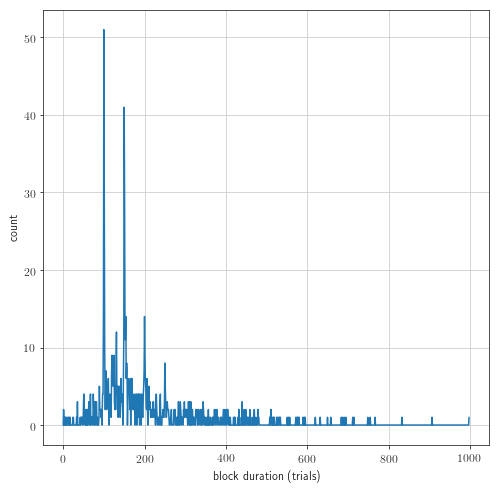

In [157]:
fig,ax=pl.subplots()
# df_data.set_index('dDate')
df_data['nPostInterval_diff']=df_data.nPostInterval.diff()
cond=df_data['nPostInterval_diff']!=0
ind_vals=np.diff(df_data[cond].index.values)
counts,bins=np.histogram(ind_vals,bins=range(1000))
ax.plot(bins[:-1],counts)
ax.set_ylabel('count')
ax.set_xlabel('block duration (trials)')
# ax.plot(diffinds,'.')
ax.

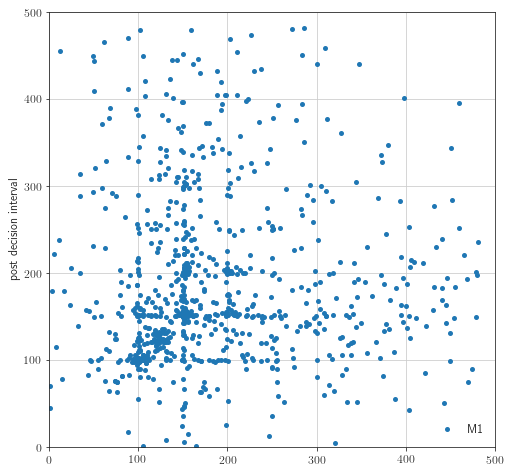

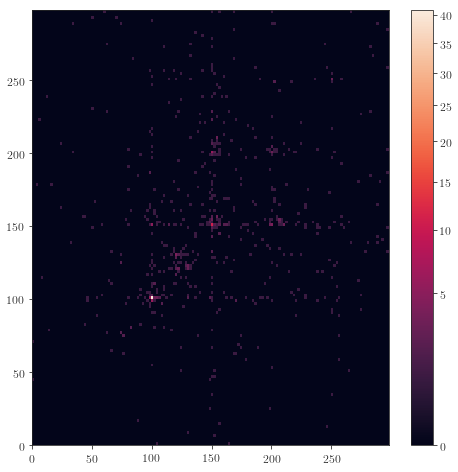

In [176]:
fig,ax=pl.subplots()
# df_data.set_index('dDate')
df_data['nPostInterval_diff']=df_data.nPostInterval.diff()
cond=df_data['nPostInterval_diff']!=0
diffinds=np.diff(df_data[cond].index.values)
ax.plot(diffinds[1:],diffinds[:-1],'.')
ax.set_xlim(0,2000)
ax.set_ylim(0,2000)
ax.set_xlim(0,500)
ax.set_ylim(0,500)
ax.legend(frameon=False,labels=['M1','M2'])
ax.set_ylabel('post decision interval')

fig,ax=pl.subplots()
import matplotlib.colors as mcolors
h=ax.hist2d(diffinds[1:], diffinds[:-1], bins=range(0,300,2),norm=mcolors.PowerNorm(0.5));
fig.colorbar(h[3],ax=ax)

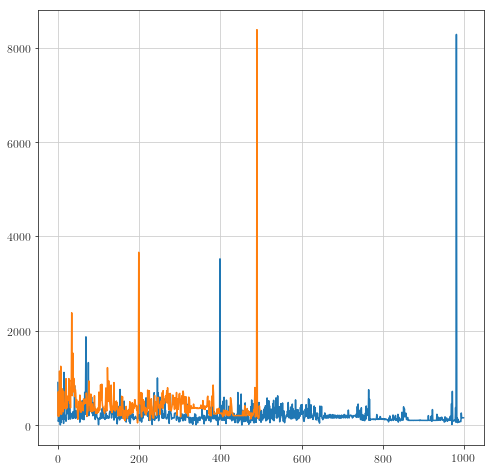

In [162]:
fig,ax=pl.subplots()
ax.plot(np.diff(df_data[cond].index.values))
ax.plot(np.diff(df_data[(df_data.nPostInterval_diff>=100)].index.values))

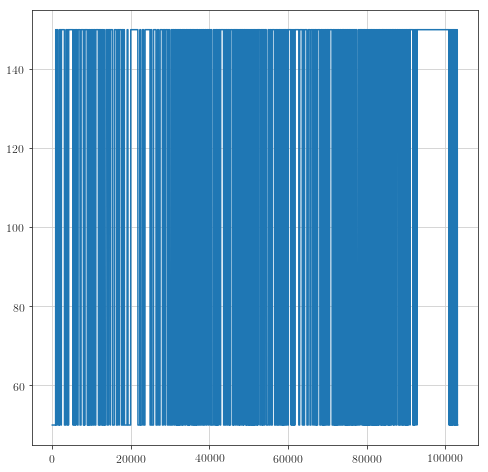

In [156]:
df_tmp=df_data[df_data.idSubject==1].copy().reset_index(drop=True)
df_tmp.nPostInterval.plot()

## Block transition analysis

Compute switch aligned datasets

215
215
285
285


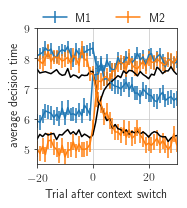

In [144]:
fig,ax=pl.subplots(figsize=(2.5,2.5))
block_ls=['-','-']
for subject in [1,2]:
    df_tmp=df_data[df_data.idSubject==subject].copy().reset_index(drop=True) #subecjt specific index

    df_tmp['nPostInterval_diff']=df_tmp.nPostInterval.diff()
    
    #group transitions by fast-to-slow and slow-to-fast 
    time_depth=100
    history=20
    num_samples=((df_tmp.nPostInterval_diff.abs()>=time_depth) & (df_tmp.nPostInterval==50)).sum()
    print(num_samples)
    data_store_fast=np.zeros((num_samples,time_depth+history))
    for it,ind in enumerate(df_tmp[(df_tmp.nPostInterval_diff.abs()>=time_depth) & (df_tmp.nPostInterval==50)].index.values[:num_samples]):
        data_store_fast[it,:]=df_tmp.iloc[ind-history:ind+time_depth].tDecision.values
    
    num_samples=((df_tmp.nPostInterval_diff.abs()>=time_depth) & (df_tmp.nPostInterval==150)).sum()
    print(num_samples)
    data_store_slow=np.zeros((num_samples,time_depth+history))
    for it,ind in enumerate(df_tmp[(df_tmp.nPostInterval_diff.abs()>=time_depth) & (df_tmp.nPostInterval==150)].index.values[:num_samples]):
        data_store_slow[it,:]=df_tmp.iloc[ind-history:ind+time_depth].tDecision.values

    #raw data
    # fig,ax=pl.subplots(2,1,figsize=(4,8))
    # ax[0].plot(data_store_slow.T);
    # ax[0].plot(np.mean(data_store_slow.T,axis=1),'k',lw=5);
    # ax[1].plot(data_store_fast.T);
    # ax[1].plot(np.mean(data_store_fast.T,axis=1),'k',lw=5);#,color=p[-1].get_color());
    # ax[0].set_xlim(0,30)
    # ax[1].set_xlim(0,30)

    #mean &sem
    lb_str=['M'+str(subject),None]
    shift=[0,0]
    for pit,data in enumerate((data_store_slow,data_store_fast)):
        me=np.mean(data,axis=0)
        sem=np.std(data,axis=0)/np.sqrt(data.shape[1])
        p=ax.errorbar(x=np.arange(-history,time_depth,dtype=float)+shift[pit],y=me,yerr=sem,label=lb_str[pit],linestyle='-',color='C'+str(subject-1));
#         p=ax.plot(np.arange(-history,time_depth),me,block_ls[pit],label=lb_str[pit],color='C'+str(subject-1));
#         ax.fill_between(np.arange(-history,time_depth), me - sem, me + sem, color=p[-1].get_color(),alpha=0.2)
    ax.set_xlabel('Trial after context switch')
    ax.set_ylabel('average decision time')
    ax.set_ylim(4.5,9)
    ax.legend(frameon=False,ncol=3,bbox_to_anchor=(1,1.2))
    ax.set_xlim(-20,30)
    
sv_vec=['slow','fast']
for tauc in [75]:
    for pit in range(2):
        me=np.load('data_tau_'+sv_vec[pit]+'_'+str(tauc)+'.npy')
        ax.plot(np.arange(-history,time_depth),me,'k-')
fig.savefig('NHP_transitions.pdf', transparent=True,bbox_inches="tight",dpi=300)

Is transition continuous or discrete in individual trials?

215
215
285
285


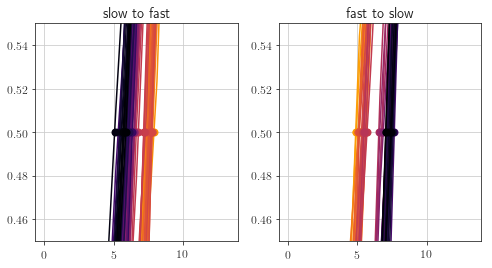

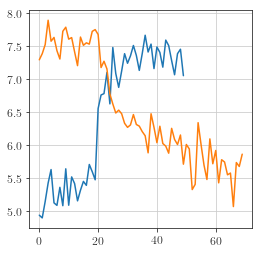

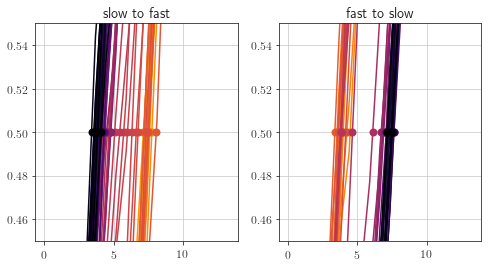

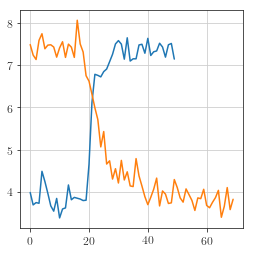

In [152]:
for subject in [1,2]:
    df_tmp=df_data[df_data.idSubject==subject].copy().reset_index(drop=True) #subecjt specific index
#     df_tmp=df_data.copy().reset_index(drop=True) 
    df_tmp['nPostInterval_diff']=df_tmp.nPostInterval.diff()
    num_samples=int(len(df_tmp)/500)
    
     #group transitions by fast-to-slow and slow-to-fast 
    time_depth=100
    history=20
    num_samples=((df_tmp.nPostInterval_diff.abs()>=time_depth) & (df_tmp.nPostInterval==50)).sum()
    print(num_samples)
    data_store_fast=np.zeros((num_samples,time_depth+history))
    for it,ind in enumerate(df_tmp[(df_tmp.nPostInterval_diff.abs()>=time_depth) & (df_tmp.nPostInterval==50)].index.values[:num_samples]):
        data_store_fast[it,:]=df_tmp.iloc[ind-history:ind+time_depth].tDecision.values
    
    num_samples=((df_tmp.nPostInterval_diff.abs()>=time_depth) & (df_tmp.nPostInterval==150)).sum()
    print(num_samples)
    data_store_slow=np.zeros((num_samples,time_depth+history))
    for it,ind in enumerate(df_tmp[(df_tmp.nPostInterval_diff.abs()>=time_depth) & (df_tmp.nPostInterval==150)].index.values[:num_samples]):
        data_store_slow[it,:]=df_tmp.iloc[ind-history:ind+time_depth].tDecision.values

        
    fig,ax=pl.subplots(1,2,figsize=(8,4))
    fig2,ax2=pl.subplots(1,1,figsize=(4,4))
    binvec=np.linspace(0,14,20)

    itmax=50
    max_counts=np.zeros(itmax)
    colorsre = pl.cm.inferno_r(np.linspace(0.2, 1., itmax))
    for it in range(itmax):
        counts,bins=np.histogram(data_store_slow[:,it],bins=binvec)
        cum=np.cumsum(counts)/np.sum(counts)
        ax[1].plot(binvec[:-1],cum,color=colorsre[it])
        maxind=np.where(0.5<cum)[0][0]
        xmin=binvec[maxind-1]
        xmax=binvec[maxind]
        m=(cum[maxind]-cum[maxind-1])/(xmax-xmin)
        max_counts[it]=(0.5-cum[maxind-1])/m+xmin#np.max(counts)
        ax[1].plot([max_counts[it]],[0.5],'o',color=colorsre[it])
    ax[0].set_ylim(0.45,0.55)
    ax[1].set_ylim(0.45,0.55)
    ax[1].set_title('fast to slow')
    ax2.plot(max_counts)

    itmax=70
    max_counts=np.zeros(itmax)
    colorsre = pl.cm.inferno_r(np.linspace(0.2, 1., itmax))
    for it in range(itmax):
        counts,bins=np.histogram(data_store_fast[:,it],bins=binvec)
        cum=np.cumsum(counts)/np.sum(counts)
        ax[0].plot(binvec[:-1],cum,color=colorsre[it])
        maxind=np.where(0.5<cum)[0][0]
        xmin=binvec[maxind-1]
        xmax=binvec[maxind]
        m=(cum[maxind]-cum[maxind-1])/(xmax-xmin)
        max_counts[it]=(0.5-cum[maxind-1])/m+xmin#np.max(counts)
        ax[0].plot([max_counts[it]],[0.5],'o',color=colorsre[it])
    ax[0].set_title('slow to fast')
    ax2.plot(max_counts)
    fig2.savefig('halfmax_data'+str(i)+'.pdf', transparent=True,bbox_inches="tight",dpi=300)


ValueError: could not broadcast input array from shape (18) into shape (100)

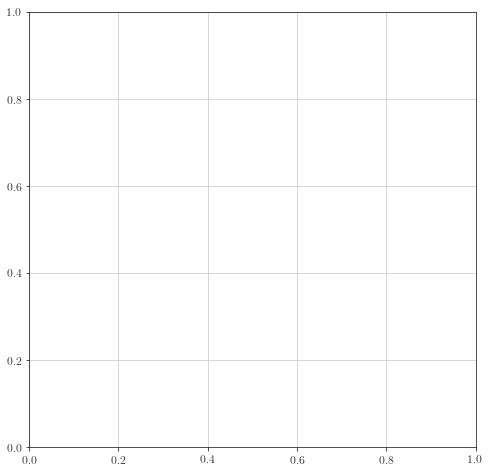

In [147]:
chunk_size=int(2e4)
fig,ax=pl.subplots()

for time in range(4):
    df_tmp=df_data[df_data.idSubject==1].copy().reset_index(drop=True).iloc[time*chunk_size:(time+1)*chunk_size].reset_index(drop=True)
#     df_tmp=df_data[(df_data.idSubject==2) & (df_data.index>=92742+time*chunk_size) & (df_data.index<92742+(time+1)*chunk_size)].copy().reset_index(drop=True)
    # df_tmp=df_data.copy().reset_index(drop=True)
    # df_tmp=df_data.copy()

    df_tmp['nPostInterval_diff']=df_tmp.nPostInterval.diff()
    num_samples=int(chunk_size/200)
    
    data_store_fast=np.zeros((num_samples,100))
    for it,ind in enumerate(df_tmp[(df_tmp.nPostInterval_diff!=0) & (df_tmp.nPostInterval==50)].index.values[:num_samples-1]):
        ind_ind=np.where(df_tmp.index.values==ind)[0][0]
        data_store_fast[it,:]=df_tmp.iloc[df_tmp.index.values[ind_ind:ind_ind+100]].tDecision.values

    data_store_slow=np.zeros((num_samples,100))
    for it,ind in enumerate(df_tmp[(df_tmp.nPostInterval_diff!=0) & (df_tmp.nPostInterval==150)].index.values[:num_samples-1]):
        data_store_slow[it,:]=df_tmp.iloc[ind:ind+100].tDecision.values
    
    # ax[0].plot(data_store_slow.T);
    p=ax.plot(np.mean(data_store_slow.T,axis=1));
    # ax[1].plot(data_store_fast.T);
    ax.plot(np.mean(data_store_fast.T,axis=1),color=p[-1].get_color());

plot correlation

In [84]:
block_times=[50,150]
T_ITI=7.5 #1500 ms with 200ms steps
T=15
# for mon in range(1,3):


df_data['T_trial']=(df_data.tDecision.values+(df_data.nPostInterval/200.)*(T-df_data.tDecision.values)+T_ITI)
df_data['RR']=df_data.pcorratDectime/(df_data.T_trial*0.2)

tcount_store=[]
rcount_store=[]
tbinvec=np.linspace(0,3.,40)
rbinvec=np.linspace(0,0.5,40)

for post_interval in block_times:
    counts,bins=np.histogram(df_data[df_data.nPostInterval==post_interval].tDecision*0.2,bins=tbinvec)
    tcount_store.append(counts)
    
    counts,bins=np.histogram(df_data[df_data.nPostInterval==post_interval].RR,bins=rbinvec)
    rcount_store.append(counts)

In [86]:
len(df_data[df_data.nPostInterval==post_interval])

133551

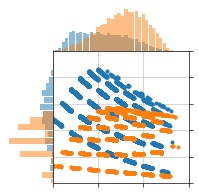

In [95]:
fig,ax=pl.subplots(nrows=2, ncols=2, gridspec_kw={'width_ratios':[1,3], 'height_ratios':[1,3]},figsize=(3.25,3.25))#,hspace=0, wspace=0)
tmax=3
ax[0,0].axis('off')
ax_corr=ax[1,1]
# ax_corr.fill_between([0,2],[0.2,0.2],[0.5,0.5],color=[0.6]*3,alpha=0.5)

ax_rew=ax[1,0]
ax_times=ax[0,1]
# offsetvec=[0.05,0.55]
offsetvec=[0.05,0.05]
bar_width=0.9
for bit,post_interval in enumerate(block_times):
    sample=df_data.loc[df_data.nPostInterval==post_interval].sample(10000)
    ax_corr.scatter(sample.tDecision*0.2,sample.RR,marker='.')#,clip_on=False)
    ax_rew.barh(rbinvec[:-1]+offsetvec[bit]*(rbinvec[1]-rbinvec[0]),rcount_store[bit],(rbinvec[1]-rbinvec[0])*bar_width,alpha=0.5,edgecolor=None,lw=0)#,color=p[-2][0].get_color())  # Stems
    ax_times.bar(tbinvec[:-1]+offsetvec[bit]*(tbinvec[1]-tbinvec[0]),tcount_store[bit],(tbinvec[1]-tbinvec[0])*bar_width,alpha=0.5,edgecolor=None,lw=0)#,color=p[-2][0].get_color())  # Stems
ax_corr.yaxis.tick_right()
ax_corr.set_ylim(0.1,0.35)
ax_corr.set_xlim(0,tmax)
ax_corr.set_xticklabels([])
ax_corr.set_yticklabels([])

ax_rew.set_ylim(0.1,0.35)
ax_rew.set_yticks([])
ax_rew.set_xlabel('frequency')
ax_rew.invert_xaxis()
ax_rew.axis('off')

ax_times.set_yticks([])
ax_times.set_xticks([])
ax_times.set_ylabel('frequency')
ax_times.axis('off')
ax_times.set_xlim(0,3)

fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig('primate_RR_RT_corr_tokens.pdf', transparent=True,bbox_inches="tight",dpi=300)

Plot decision times

In [148]:
from scipy.interpolate import griddata
def plot_dec_times(df_data,pl,dataset_name,axbase,ax,ymax=None,T=15,start_time=None,itera=0):
    '''
    Computes empirical action policy distributions from a sample ensemble of trials held in the dataframe df_data 
    '''

    if (df_data.tDecision.values==0).sum():
        print('some decisions at t=0!')
        
    ###count distributions of decision events in (N_p,N_m) space 
    dec_counts=np.zeros((T+1,T+1))
    dec_R_counts=np.zeros((T+1,T+1))
    dec_L_counts=np.zeros((T+1,T+1))
    dec_wait_counts=np.zeros((T+1,T+1))
    for it,tdec in enumerate(df_data.tDecision.values):
        curr_traj=df_data.seq.iloc[it]
        #over all trajs 
        dec_counts[np.sum(curr_traj[:int(tdec)]==1),np.sum(curr_traj[:int(tdec)]==-1)]+=1 #increment occupancy at given (Np,Nm). int rounds down so should include current state. -1 to map to traj time index,
        #over trajs|action
        if df_data.nChoiceMade.iloc[it]==1:
            dec_R_counts[np.sum(curr_traj[:int(tdec)]==1),np.sum(curr_traj[:int(tdec)]==-1)]+=1 #increment occupancy at given (Np,Nm)
        else:# trial_dec[it]==-1:
            dec_L_counts[np.sum(curr_traj[:int(tdec)]==1),np.sum(curr_traj[:int(tdec)]==-1)]+=1 #increment occupancy at given (Np,Nm)
        for sit in range(1,int(tdec)): #add wait action up to decision
            dec_wait_counts[np.sum(curr_traj[:sit-1]==1),np.sum(curr_traj[:sit-1]==-1)]+=1 #increment occupancy at given (Np,Nm    
    #add t=0 data
    dec_counts[0,0]=(df_data.tDecision==0).sum()
    dec_R_counts[0,0]=((df_data.tDecision==0) & (df_data.nChoiceMade==1)).sum()
    dec_L_counts[0,0]=((df_data.tDecision==0) & (df_data.nChoiceMade==-1)).sum()
    dec_wait_counts[0,0]=len(df_data)-dec_R_counts[0,0]-dec_L_counts[0,0]
    
    
    mesh=np.meshgrid(range(T+1),range(T+1))
    Npvec=mesh[0].flatten()
    Nmvec=mesh[1].flatten()
    tvec=Npvec+Nmvec
    Nvec=Npvec-Nmvec
    for Np in range(T+1):
        for Nm in range(T+1):
            axbase.scatter(tvec.flatten(),Nvec.flatten(),s=160000*(dec_counts/np.sum(dec_counts)).flatten()**2,marker='+',linewidth=3)
    for Np in range(T+1):
        for Nm in range(T+1):
            if Np+Nm< T+1:
                axbase.scatter(Np+Nm,Np-Nm,s=5,facecolor='w',edgecolor='k',lw=0.5)
    axbase.set_xticks([0,1/3*T,2/3*T,T])
    axbase.set_yticks([-10,0,2/3*T])
    axbase.set_xlim([0,15])
    ###state occupancy count distributions in (N_p,N_m) space
    occupancy_counts=np.zeros((T+1,T+1))
    occupancy_predec_counts=np.zeros((T+1,T+1))
    surv_prob=np.zeros((T+1,T+1))
    Nt_samples=np.cumsum(np.asarray(df_data.seq.tolist()),axis=1) #note that this starts at t=1, so indexing adjusted by -1 below.
    tdec_vec=df_data.tDecision.apply(lambda x:int(x)).values
    for Np in np.arange(T+1):
        for Nm in np.arange(T+1):
            if Np+Nm<=T and Np+Nm>0:#=0
                occupancy_counts[Np,Nm]=np.sum(Nt_samples[:,Np+Nm-1]==Np-Nm)      
                occupancy_predec_counts[Np,Nm]=np.sum(Nt_samples[tdec_vec-1>=Np+Nm-1,Np+Nm-1]==Np-Nm) 
                surv_prob[Np,Nm]=np.sum(tdec_vec[Nt_samples[:,Np+Nm-1]==Np-Nm]>Np+Nm)/occupancy_counts[Np,Nm]
                                          
                #of ones that get here, what fraction have yet to decide
    surv_prob[0,0]=1  
    surv_prob[np.isnan(surv_prob)]=0
    occupancy_counts[0,0]=len(df_data) #all trajs go through (N_p=0,N_m=0).
    occupancy_predec_counts[0,0]=len(df_data)  #all trajs go through (N_p=0,N_m=0).
    
#     dec_dist=np.where(occupancy_predec_counts>0,dec_counts/occupancy_predec_counts,0)#*occupancy_counts/len(df_data)*10
    dec_dist=surv_prob#np.where(occupancy_predec_counts>0,dec_counts/occupancy_predec_counts,0)#*occupancy_counts/len(df_data)*10

#     ###combine to form state frequency distributions
#     dist_tmp=np.zeros(dist.shape)
#     dist_R_tmp=np.zeros(dist_R.shape)
#     dist_L_tmp=np.zeros(dist_L.shape)
#     dist_wait_tmp=np.zeros(dist_L.shape)
#     for Np in range(T+1):
#         for Nm in range(T+1):
#             if occupancy_dist[Np,Nm]>0:
# #             if dist[Np,Nm]>0:
#                 dist_tmp[Np,Nm]=dist[Np,Nm]/occupancy_pre_dist[Np,Nm] if occupancy_pre_dist[Np,Nm]>0 else 0
#                 dist_R_tmp[Np,Nm]=dist_R[Np,Nm]/occupancy_dist[Np,Nm] 
#                 dist_L_tmp[Np,Nm]=dist_L[Np,Nm]/occupancy_dist[Np,Nm] 
#                 dist_wait_tmp[Np,Nm]=1.-dist_R_tmp[Np,Nm] - dist_L_tmp[Np,Nm]#dist_wait[Np,Nm]/occupancy_dist[Np,Nm]   
# #                 dist_R_tmp[Np,Nm]=dist_R[Np,Nm]/dist[Np,Nm] 
# #                 dist_L_tmp[Np,Nm]=dist_L[Np,Nm]/dist[Np,Nm] 
# #                 dist_wait_tmp[Np,Nm]= dist_wait[Np,Nm]/dist[Np,Nm] 
#     dist=dist_tmp
#     dist_R=dist_R_tmp
#     dist_L=dist_L_tmp
#     dist_wait=dist_wait_tmp
    
    ###plot on smoothed coordinates.
    mesh=np.meshgrid(range(T+1),range(T+1))
    Npvec=mesh[0].flatten()
    Nmvec=mesh[1].flatten()
    tvec=Npvec+Nmvec
    Nvec=Npvec-Nmvec
    tvecdense=np.linspace(min(tvec),max(tvec),100)
    Nvecdense=np.linspace(min(Nvec),max(Nvec),100)
    #normalize dist for [0,1] colorscale
    z_d=griddata((tvec,Nvec),dec_dist.flatten(), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')
    
#     z_R=griddata((tvec,Nvec),dist_R.flatten(), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')
#     z_L=griddata((tvec,Nvec),dist_L.flatten(), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')
#     z_wait=griddata((tvec,Nvec),dist_wait.flatten(), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')
# #     z_R=griddata((tvec,Nvec),dist_R.flatten()/np.sum(np.sum(dist_R)), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')
# #     z_L=griddata((tvec,Nvec),dist_L.flatten()/np.sum(np.sum(dist_L)), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')
# #     z_wait=griddata((tvec,Nvec),dist_wait.flatten()/np.sum(np.sum(dist_wait)), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')
#     print(dist_wait[0,0])
#     fig, ax=pl.subplots(1,4,frameon=False,figsize=(26,7))
#     strp=['left','right','wait']
#     zvec=[z_R,z_L,z_wait] #wrong order here, because something above is in wrong order...
#     for p,z in enumerate(zvec):
#         z[z<0]=0
#         z[z>1]=1
#         CS=ax[p].contourf(tvecdense,Nvecdense,z,30,cmap=pl.cm.jet,vmax=1., vmin=0.)
#         if p==0:
#             ax[p].set_ylabel(r'token difference, $N_t$')
#         else:
#             ax[p].set_yticklabels('')
#         ax[p].set_xlim(0,T)
#         ax[p].set_ylim(-T,T)
#         ax[p].set_xticks([0,1/3*T,2/3*T,T])
#         ax[p].set_xlabel(r'time, $t$')
#         ax[p].set_title(r'$a=\textrm{'+strp[p]+'}$')
#         for Np in range(T+1):
#             for Nm in range(T+1):
#                 if Np+Nm< T+1:
#                     ax[p].scatter(Np+Nm,Np-Nm,s=10,facecolor='w',edgecolor='k',lw=0.5)
#     ax[2].figure.colorbar(CS)
#     #response time distirbutions
#     df_data.tDecision.hist(ax=ax[3],bins=np.arange(T+2)-0.5,density=True)
# #     t_dist=np.zeros((T+1,))
# #     for t in range(T+1):
# #         t_dist[t]=np.diagonal(np.flipud(dist),offset=-(T)+t).mean() #marginalize over state
# #     ax[3].bar(range(T+1),t_dist)
#     ax[3].set_ylabel('frequency')
#     ax[3].set_xlabel(r'time, $t$')
#     ax[3].set_xlim(0,T)
#     ax[3].set_xticks([0,1/3*T,2/3*T,T])
#     ax[3].set_title('commitment time histogram')
#     ax[3].set_ylim(0,ymax)

#     fig.tight_layout()
#     fig.suptitle(r'empirical primate policy, $\pi(a|s=(N_t,t))$',y=1.05)
#     fig.savefig('primate_policy_poster_'+dataset_name+'.pdf', transparent=True,bbox_inches="tight",dpi=300)
    
    point=8
    offset=0.5
    ax.fill_between(-offset+np.arange(point,2*point+1),-offset+point-np.arange(point+1),-offset+point+np.arange(point+1),color=[0.6,0.6,0.6],zorder=5)
    ax.fill_between(-offset+np.arange(point,2*point+1),offset-point-np.arange(point+1),offset-point+np.arange(point+1),color=[0.6,0.6,0.6],zorder=5)
    for Nm in 2*np.arange(T):
        ax.plot(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2,'ko',ms=1,lw=0.5,color='k',mew=0.5,mfc='k',mec='k',zorder=20)
    for Np in 2*np.arange(T):
        ax.plot(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2,'ko',ms=1,lw=0.5,color='k',mew=0.5,mfc='k',mec='k',zorder=20)
#     for Np in range(T+1):
#         for Nm in range(T+1):
#             ax.scatter(tvec.flatten(),Nvec.flatten(),s=500*dec_dist.flatten()**2,marker='+',linewidth=3)
            
    #prob of deciding
#     fig, ax=pl.subplots(1,1,figsize=(6,4))#frameon=False,
    z_d[z_d<0]=0
#     z_d[z_d>1]=1
#     z_d[np.isnan(z_d)]=-np.Inf
#     print(np.sum((np.isnan(z_d))))
#     print(z_d)
    CS=ax.contourf(tvecdense,Nvecdense,z_d,30,cmap=pl.cm.twilight,vmax=1., vmin=0.)#,alpha=0.8)
#     CS=ax.contourf(tvecdense,Nvecdense,z_d,30,zorder=2)
    ax.contour(tvecdense,Nvecdense,z_d,levels=[0.5],linewidths=(1.5,),colors=('w'),linestyles=('dotted'),zorder=15)
#     ax.grid()
#     ax.figure.colorbar(CS)
#     ax.set_ylabel(r'token difference, $N_t$')
#     ax.set_yticklabels('')
    ax.set_xlim(0,T)
    ax.set_ylim(-T,T)
    ax.set_xticks([0,1/3*T,2/3*T,T])
#     ax.set_xlabel(r'time, $t$')
#     ax.set_title(r'$\textrm{Pr}(\textrm{decide}|N_t,t)$')
#     ax.set_title(r'$t='+str(start_time)+'$')
#     ax.axis('off')
    point=8
    offset=0.5
    axbase.fill_between(-offset+np.arange(point,2*point+1),-offset+point-np.arange(point+1),-offset+point+np.arange(point+1),color=[0.6,0.6,0.6])
    axbase.fill_between(-offset+np.arange(point,2*point+1),offset-point-np.arange(point+1),offset-point+np.arange(point+1),color=[0.6,0.6,0.6])
#     for Np in range(T+1):
#         for Nm in range(T+1):
#             if Np+Nm< T+1:
#                 ax.scatter(Np+Nm,Np-Nm,s=5,facecolor='w',edgecolor='k',lw=0.5)
    
#     axbase.imshow(dec_counts[:8,:8],origin='lower')  
    for Nm in 2*np.arange(T):
        axbase.plot(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2,'ko',ms=0.5,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
    for Np in 2*np.arange(T):
        axbase.plot(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2,'ko',ms=0.5,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
#     fig.savefig('primate_policy_poster_P_dec_'+dataset_name+'.pdf', transparent=True,bbox_inches="tight",dpi=300)
    
    
    
#     fig, ax=pl.subplots(1,1,frameon=False,figsize=(6,4))
#     CS=ax.contourf(tvecdense,Nvecdense,(z_L+z_R)/2,30,cmap=pl.cm.jet)
#     ax.set_ylabel(r'token difference, $N_t$')
# #     ax.set_yticklabels('')
#     ax.set_xlim(0,T)
#     ax.set_ylim(-T,T)
#     ax.set_xticks([0,1/3*T,2/3*T,T])
#     ax.set_xlabel(r'time, $t$')
#     ax.set_title(r'$\textrm{Pr}(\textrm{decide}|N_t,t)$')
# #     ax.set_title(r'$t='+str(start_time)+'$')
# #     ax.axis('off')
    
#     for Np in range(T+1):
#         for Nm in range(T+1):
#             if Np+Nm< T+1:
#                 ax.scatter(Np+Nm,Np-Nm,s=10,facecolor='w',edgecolor='k',lw=0.5)
#     ax.figure.colorbar(CS)

     #accuracy bias
    in_count=0
    out_count=0
    for Np in range(T+1):
        for Nm in range(T+1):
            if Np>=8 or Nm>=8:
                in_count+=dec_dist[Np,Nm]
            else:
                out_count+=dec_dist[Np,Nm]
                
    return CS#(in_count-out_count)/np.sum(dec_dist)

In [36]:
from scipy.interpolate import griddata
def plot_dec_times(df_data,pl,dataset_name,ymax=1,T=15,ax=ax):#,ax2=None):
# df_data=dftmp
# dataset_name='monkey_pcorr_'+str(i)+'_post_'+str(post_interval)
    '''
    Computes empirical action policy distributions from a sample ensemble of trials held in the dataframe df_data 
    '''

    if (df_data.tDecision.values==0).sum():
        print(str((df_data.tDecision.values==0).sum())+' decisions at t=0!')
    if (df_data.tDecision.values<0).sum():
        print(str((df_data.tDecision.values<0).sum())+' decisions before t=0!')

    ###count distributions of decision events in (N_p,N_m) space 
    dist=np.zeros((T+1,T+1))
    dist_R=np.zeros((T+1,T+1))
    dist_L=np.zeros((T+1,T+1))
    dist_wait=np.zeros((T+1,T+1))
    for it,tdec in enumerate(df_data.tDecision.values):
        curr_traj=df_data.seq.iloc[it]

        #indexing logic: 
        #-int rounds tdec down to last token jump time, t, (i.e. current evidence), 
        #-curr_traj starts at t=0 so curr_traj[:t] gives t token jumps
        #over all trajs 
        dist[np.sum(curr_traj[:int(tdec)]==1),np.sum(curr_traj[:int(tdec)]==-1)]+=1 #increment occupancy at given (Np,Nm). int rounds down so should include current state. -1 to map to traj time index,
        #over trajs|action
        if df_data.nChoiceMade.iloc[it]==1:
            dist_R[np.sum(curr_traj[:int(tdec)]==1),np.sum(curr_traj[:int(tdec)]==-1)]+=1 #increment occupancy at given (Np,Nm)
        else:# df_data.nChoiceMade.iloc[it]==-1:
            dist_L[np.sum(curr_traj[:int(tdec)]==1),np.sum(curr_traj[:int(tdec)]==-1)]+=1 #increment occupancy at given (Np,Nm)
        for sit in range(1,int(tdec)): #add wait action up to decision
            dist_wait[np.sum(curr_traj[:sit-1]==1),np.sum(curr_traj[:sit-1]==-1)]+=1 #increment occupancy at given (Np,Nm)

    dist_corr=np.zeros((T+1,T+1))
    for it,tdec in enumerate(df_data.tDecision.values):
        curr_traj=df_data.seq.iloc[it]
        #over all trajs 
        dist_corr[np.sum(curr_traj[:int(tdec)]==1),np.sum(curr_traj[:int(tdec)]==-1)]+=(df_data.nChoiceMade.iloc[it]==df_data.nCorrectChoice.iloc[it])

    #add t=0 data
    dist[0,0]=(df_data.tDecision==0).sum()
    dist_R[0,0]=((df_data.tDecision==0) & (df_data.nChoiceMade==1)).sum()
    dist_L[0,0]=((df_data.tDecision==0) & (df_data.nChoiceMade==-1)).sum()
    dist_wait[0,0]=len(df_data)-dist_R[0,0]-dist_L[0,0]
    print(dist_wait[0,0])

    ###state occupancy count distributions in (N_p,N_m) space
    occupancy_dist=np.zeros((T+1,T+1))
    Nt_samples=np.cumsum(np.asarray(df_data.seq.tolist()),axis=1) #note that this starts at t=1, so indexing adjusted by -1 below.
    tdec_vec=df_data.tDecision.apply(lambda x:int(x)).values
    for Np in np.arange(T+1):
        for Nm in np.arange(T+1):
            if Np+Nm<=T and Np+Nm>0:#=0
#                 occupancy_dist[Np,Nm]=np.sum(Nt_samples[:,Np+Nm-1]==Np-Nm)
                occupancy_dist[Np,Nm]=np.sum(Nt_samples[tdec_vec-1>=Np+Nm-1 ,Np+Nm-1]==Np-Nm)    
    occupancy_dist[0,0]=len(df_data) #all trajs go through (N_p=0,N_m=0).

    ###combine to form state frequency distributions
    dist_tmp=np.zeros(dist.shape)
    dist_R_tmp=np.zeros(dist_R.shape)
    dist_L_tmp=np.zeros(dist_L.shape)
    dist_wait_tmp=np.zeros(dist_L.shape)
    dist_corr_tmp=np.zeros(dist_L.shape)
    for Np in range(T+1):
        for Nm in range(T+1):
            if occupancy_dist[Np,Nm]>0:
    #             if dist[Np,Nm]>0:
                dist_tmp[Np,Nm]=dist[Np,Nm]/occupancy_dist[Np,Nm]
                dist_R_tmp[Np,Nm]=dist_R[Np,Nm]/occupancy_dist[Np,Nm] 
                dist_L_tmp[Np,Nm]=dist_L[Np,Nm]/occupancy_dist[Np,Nm] 
                dist_wait_tmp[Np,Nm]=1.-dist_R_tmp[Np,Nm] - dist_L_tmp[Np,Nm]#dist_wait[Np,Nm]/occupancy_dist[Np,Nm]   
                dist_corr_tmp[Np,Nm]=dist_corr[Np,Nm]/dist[Np,Nm] 

                #                 dist_R_tmp[Np,Nm]=dist_R[Np,Nm]/dist[Np,Nm] 
    #                 dist_L_tmp[Np,Nm]=dist_L[Np,Nm]/dist[Np,Nm] 
    #                 dist_wait_tmp[Np,Nm]= dist_wait[Np,Nm]/dist[Np,Nm] 
    dist=dist_tmp
    dist_R=dist_R_tmp
    dist_L=dist_L_tmp
    dist_wait=dist_wait_tmp
    dist_corr=dist_corr_tmp

    ###plot on smoothed coordinates.
    mesh=np.meshgrid(range(T+1),range(T+1))
    Npvec=mesh[0].flatten()
    Nmvec=mesh[1].flatten()
    tvec=Npvec+Nmvec
    Nvec=Npvec-Nmvec
    tvecdense=np.linspace(min(tvec),max(tvec),100)
    Nvecdense=np.linspace(min(Nvec),max(Nvec),100)
    #normalize dist for [0,1] colorscale
    z_d=griddata((tvec,Nvec),dist.flatten(), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')

    z_R=griddata((tvec,Nvec),dist_R.flatten(), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')
    z_L=griddata((tvec,Nvec),dist_L.flatten(), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')
    z_wait=griddata((tvec,Nvec),dist_wait.flatten(), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')
    #     z_R=griddata((tvec,Nvec),dist_R.flatten()/np.sum(np.sum(dist_R)), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')
    #     z_L=griddata((tvec,Nvec),dist_L.flatten()/np.sum(np.sum(dist_L)), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')
    #     z_wait=griddata((tvec,Nvec),dist_wait.flatten()/np.sum(np.sum(dist_wait)), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')


#     print(dist_wait[0,0])
#     fig, ax=pl.subplots(1,4,frameon=False,figsize=(26,7))
#     strp=['left','right','wait']
#     zvec=[z_R,z_L,z_wait] #wrong order here, because something above is in wrong order...
#     for p,z in enumerate(zvec):
#         z[z<0]=0
#         z[z>1]=1
#         CS=ax[p].contourf(tvecdense,Nvecdense,z,30,cmap=pl.cm.jet,vmax=1., vmin=0.)
#         if p==0:
#             ax[p].set_ylabel(r'token difference, $N_t$')
#         else:
#             ax[p].set_yticklabels('')
#         ax[p].set_xlim(0,T)
#         ax[p].set_ylim(-T,T)
#         ax[p].set_xticks([0,1/3*T,2/3*T,T])
#         ax[p].set_xlabel(r'time, $t$')
#         ax[p].set_title(r'$a=\textrm{'+strp[p]+'}$')
#         for Np in range(T+1):
#             for Nm in range(T+1):
#                 if Np+Nm< T+1:
#                     ax[p].scatter(Np+Nm,Np-Nm,s=10,facecolor='w',edgecolor='k',lw=0.5)
#     ax[2].figure.colorbar(CS)
#     #response time distirbutions
#     df_data.tDecision.hist(ax=ax[3],bins=np.arange(T+2)-0.5,density=True)
# #     t_dist=np.zeros((T+1,))
# #     for t in range(T+1):
# #         t_dist[t]=np.diagonal(np.flipud(dist),offset=-(T)+t).mean() #marginalize over state
# #     ax[3].bar(range(T+1),t_dist)
#     ax[3].set_ylabel('frequency')
#     ax[3].set_xlabel(r'time, $t$')
#     ax[3].set_xlim(0,T)
#     ax[3].set_xticks([0,1/3*T,2/3*T,T])
#     ax[3].set_title('commitment time histogram')
#     ax[3].set_ylim(0,ymax)

#     fig.tight_layout()
#     fig.suptitle(r'empirical primate policy, $\pi(a|s=(N_t,t))$',y=1.05)
#     fig.savefig('primate_policy_poster_'+dataset_name+'.pdf', transparent=True,bbox_inches="tight",dpi=300)

#     #prob of deciding
#     fig, ax=pl.subplots(1,1,frameon=False,figsize=(3,2))
#     z_d[z_d<0]=0
#     CS=ax.contourf(tvecdense,Nvecdense,z_d,30,cmap=pl.cm.jet)
#     ax.set_ylabel(r'token difference, $N_t$')
#     ax.set_yticklabels('')
#     ax.set_xlim(0,T)
#     ax.set_ylim(-T,T)
#     ax.set_xticks([0,1/3*T,2/3*T,T])
#     ax.set_xlabel(r'time, $t$')
#     ax.set_title(r'$\textrm{Pr}(\textrm{decide}|N_t,t)$')
#     ax.axis('off')
#     for Np in range(T+1):
#         for Nm in range(T+1):
#             if Np+Nm< T+1:
#                 ax.scatter(Np+Nm,Np-Nm,s=10,facecolor='w',edgecolor='k',lw=0.5)
#     ax.figure.colorbar(CS)
#     fig.savefig('primate_policy_poster_P_dec_'+dataset_name+'.pdf', transparent=True,bbox_inches="tight",dpi=300)

#         z_corr=griddata((tvec,Nvec),dist_corr.flatten(), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')
#         fig, ax=pl.subplots(1,1,frameon=False,figsize=(3,2))
#     #     z_corr[z_d<0]=0
#         CS=ax.contourf(tvecdense,Nvecdense,z_corr,30,cmap=pl.cm.jet)
#         ax.set_ylabel(r'token difference, $N_t$')
#         ax.set_yticklabels('')
#         ax.set_xlim(0,T)
#         ax.set_ylim(-T,T)
#         ax.set_xticks([0,1/3*T,2/3*T,T])
#         ax.set_xlabel(r'time, $t$')
#         ax.set_title(r'$\textrm{Pr}(\textrm{correct}|N_t,t)$')
#         ax.axis('off')
#         for Np in range(T+1):
#             for Nm in range(T+1):
#                 if Np+Nm< T+1:
#                     ax.scatter(Np+Nm,Np-Nm,s=10,facecolor='w',edgecolor='k',lw=0.5)
#         ax.figure.colorbar(CS)
    
    
    
  ##the 2D histogram plots  
#     from mpl_toolkits.mplot3d import Axes3D
#     fig=pl.figure()

#     ax=fig.add_subplot(111,projection='3d')
#     x,y=np.meshgrid(range(T+1),range(T+1))
#     dist=dist.flatten()
#     ax.bar3d(x.flatten(),y.flatten(),np.zeros(dist.shape),np.ones(dist.shape),np.ones(dist.shape),dist)
    
    
 ## the Pcorr belief space plot
    #for Nm in np.arange(T+1):
    #    ax.plot(np.arange(T+1-Nm)+Nm,dist_corr[:T+1-Nm,Nm],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
    #for Np in np.arange(T+1):
    #    ax.plot(np.arange(T+1-Np)+Np,dist_corr[Np,:T+1-Np],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
   
    error=np.sqrt(dist_corr*(1-dist_corr)/dist)
    for Nm in np.arange(T+1):
        if Nm==0:
            p=ax.errorbar(np.arange(T+1-Nm)+Nm+ymax,dist_corr[:T+1-Nm,Nm],yerr=error[:T+1-Nm,Nm],fmt='o',ms=3,lw=0.5,mew=0.5)
            col=p[-1][0].get_color()[0]
            print(p[-1][0].get_color())
        else:
            ax.errorbar(np.arange(T+1-Nm)+Nm+ymax,dist_corr[:T+1-Nm,Nm],yerr=error[:T+1-Nm,Nm],fmt='o',ms=3,lw=0.5,color=col,mew=0.5)

    for Np in np.arange(T+1):
        ax.errorbar(np.arange(T+1-Np)+Np+ymax,dist_corr[Np,:T+1-Np],yerr=error[Np,:T+1-Np],fmt='o',ms=3,lw=0.5,color=col,mew=0.5)
    
    #other
    for Nm in range(T+1):
        plus=[get_pt_plus(15,t,Nt) if Nt>0 else 1-get_pt_plus(15,t,Nt)  for t,Nt in zip(np.arange(T+1-Nm)+Nm,np.arange(T+1-Nm)-Nm)]
        
        if Nm==0:
            p=ax2.scatter(plus,dist_corr[:T+1-Nm,Nm],marker='.')
#             col=p[-1][0].get_color()
#             print(p[-1][0].get_color())
        else:
            ax2.scatter(plus,dist_corr[:T+1-Nm,Nm],marker='.',color=col)
    #other
#     for Nm in range(T+1):
#         plus=[get_pt_plus(15,t,Nt) if Nt>0 else 1-get_pt_plus(15,t,Nt)  for t,Nt in zip(np.arange(T+1-Nm)+Nm,np.arange(T+1-Nm)-Nm)]
        
#         if Nm==0:
#             p=ax2.scatter(plus,dist[:T+1-Nm,Nm],marker='.')
# #             col=p[-1][0].get_color()
# #             print(p[-1][0].get_color())
#         else:
#             ax2.scatter(plus,dist[:T+1-Nm,Nm],marker='.',color=col)
            

#         np.save('primate_p_success_'+dataset_name+'.npy',dist_corr)
#         np.save('primate_p_success_'+dataset_name+'_num.npy',dist)

In [43]:
dftmp=df_data[(df_data.idSubject==i) & (df_data.nPostInterval==post_interval)].reset_index()
plot_dec_times(dftmp,pl,'monkey_pcorr_'+str(i)+'_post_'+str(post_interval),ymax=0.2)

18 decisions before t=0!
66897.0


/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in double_scalars
/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in double_scalars
/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/ipykernel_launcher.py:189: RuntimeWarning: invalid value encountered in true_divide
/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/ipykernel_launcher.py:189: RuntimeWarning: invalid value encountered in sqrt


In [17]:
df_data['Nt']=df_data.seq.apply(lambda x: np.insert(np.cumsum(x),0,0))

../lib/utils/ipynb_setup.py:161: RuntimeWarning: invalid value encountered in less
../lib/utils/ipynb_setup.py:161: RuntimeWarning: invalid value encountered in less
../lib/utils/ipynb_setup.py:59: RuntimeWarning: invalid value encountered in true_divide
../lib/utils/ipynb_setup.py:161: RuntimeWarning: invalid value encountered in less


some decisions at t=0!


../lib/utils/ipynb_setup.py:59: RuntimeWarning: invalid value encountered in true_divide
../lib/utils/ipynb_setup.py:161: RuntimeWarning: invalid value encountered in less


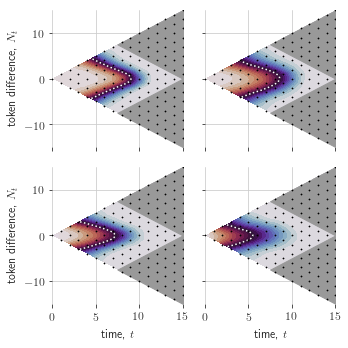

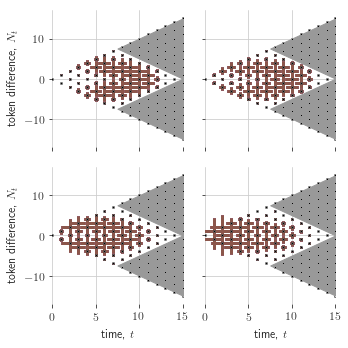

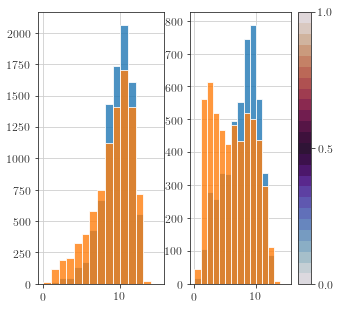

In [150]:
block_times=[150,50]
fig,ax=pl.subplots(2,2,figsize=(5,5))
figbase,axbase=pl.subplots(2,2,figsize=(5,5))
figamb,axamb=pl.subplots(1,2,figsize=(5,5))
bias_store=np.zeros((2,2))
for i in range(1,3):
    for pit,post_interval in enumerate(block_times):
        dftmp=df_data[(df_data.idSubject==i) & (df_data.nPostInterval==post_interval)].reset_index()
        bias=plot_dec_times(dftmp,pl,'monkey_'+str(i)+'_post_'+str(post_interval),axbase[pit,i-1,],ax[pit,i-1],i-1+pit)#,ymax=0.3)
#         bias_store[pit,i-1]=bias
        axbase[pit,i-1].set_frame_on(False)
        ax[pit,i-1].set_frame_on(False)
#         axbase[i-1,pit]=figb
#         ax[i-1,pit]=fignorm
        xran=2 # limit of abs value of state
        amb_trajs_idx=dftmp['Nt'].apply(lambda x: not np.any(x>xran) and not np.any(x<-xran))

        dftmp[amb_trajs_idx]['tDecision'].hist(ax=axamb[pit],bins=np.arange(16),alpha=0.8)
ax[0,1].set_yticklabels([])
ax[1,1].set_yticklabels([])
ax[0,0].set_xticklabels([])
ax[0,1].set_xticklabels([])
axbase[0,1].set_yticklabels([])
axbase[1,1].set_yticklabels([])
axbase[0,0].set_xticklabels([])
axbase[0,1].set_xticklabels([])
ax[0,0].set_ylabel('token difference, $N_t$')
ax[1,0].set_ylabel(r'token difference, $N_t$')
ax[1,0].set_xlabel(r'time, $t$')
ax[1,1].set_xlabel(r'time, $t$')
axbase[0,0].set_ylabel('token difference, $N_t$')
axbase[1,0].set_ylabel(r'token difference, $N_t$')
axbase[1,0].set_xlabel(r'time, $t$')
axbase[1,1].set_xlabel(r'time, $t$')
pl.colorbar(bias,ticks=[0, 0.5,1])
fig.tight_layout()
figbase.tight_layout()
fig.savefig('primate_occu.pdf', transparent=True,bbox_inches="tight",dpi=300)
figbase.savefig('primate_survprob.pdf', transparent=True,bbox_inches="tight",dpi=300)


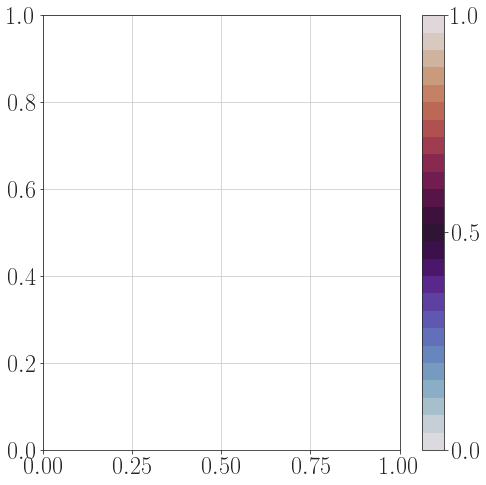

In [79]:
pl.colorbar(bias,ticks=[0, 0.5,1])
pl.savefig('colorbar.pdf', transparent=True,bbox_inches="tight",dpi=300)

In [197]:
figbase.savefig('primate_policy_poster_P_dec.pdf', transparent=True,bbox_inches="tight",dpi=300)
fig.savefig('primate_policy_poster_P_dec_norm.pdf', transparent=True,bbox_inches="tight",dpi=300)

66897.0


/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in less


36274.0
66654.0
some decisions at t=0!
39408.0


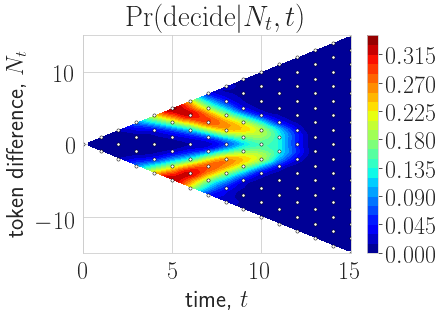

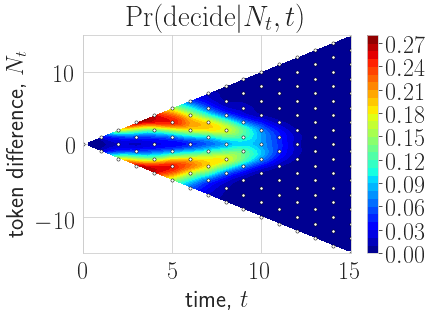

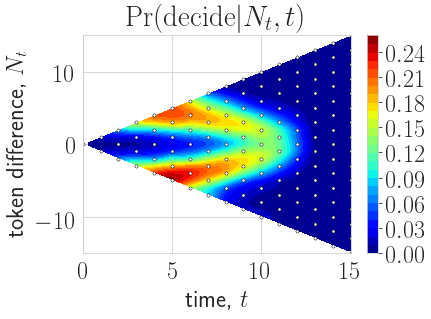

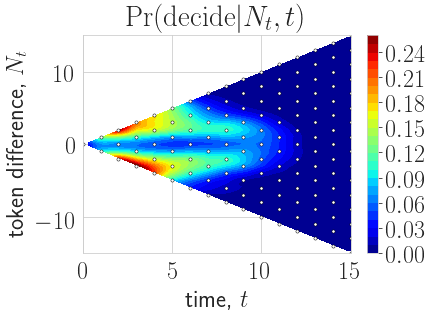

In [125]:
block_times=[150,50]
for i in range(1,3):
    for pit,post_interval in enumerate(block_times):
        dftmp=df_data[(df_data.idSubject==i) & (df_data.nPostInterval==post_interval)].reset_index()
        plot_dec_times(dftmp,pl,'monkey_'+str(i)+'_post_'+str(post_interval),ymax=0.3)


In [69]:
fig.savefig('acccuracy_nogrid.png', transparent=True,dpi=300)

18 decisions before t=0!
66897.0


C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:220: RuntimeWarning: invalid value encountered in true_divide
C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:220: RuntimeWarning: invalid value encountered in sqrt


[[0.12156863 0.46666667 0.70588235 1.        ]]
23 decisions before t=0!
36274.0
[[1.         0.49803922 0.05490196 1.        ]]
39 decisions before t=0!
66654.0
[[0.17254902 0.62745098 0.17254902 1.        ]]
1 decisions at t=0!
101 decisions before t=0!
39408.0
[[0.83921569 0.15294118 0.15686275 1.        ]]


C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars


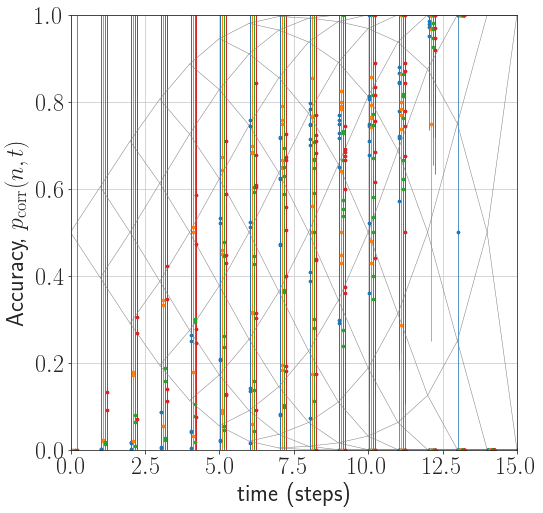

In [37]:
block_times=[150,50]
fig,ax=pl.subplots()
for i in range(1,3):
    for pit,post_interval in enumerate(block_times):
        dftmp=df_data[(df_data.idSubject==i) & (df_data.nPostInterval==post_interval)].reset_index()
        plot_dec_times(dftmp,pl,'monkey_pcorr_'+str(i)+'_post_'+str(post_interval),ymax=(i*2+pit-1.5)/1.5/10,ax=ax)
T=15
T=15
for Nm in 2*np.arange(T):
    ax.plot(np.arange(T+1-Nm/2)+Nm/2,[get_pt_plus(15,t,Nt) for t,Nt in zip(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2)],'-',ms=5,lw=0.5,color=[0.5]*3,mew=0.5,mfc='k',mec='k')
for Np in 2*np.arange(T):
    ax.plot(np.arange(T+1-Np/2)+Np/2,[1-get_pt_plus(15,t,Nt) for t,Nt in zip(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2)],'-',ms=5,lw=0.5,color=[0.5]*3,mew=0.5,mfc='k',mec='k')
ax.set_ylim(0,1)
ax.set_xlim(0,15)
ax.set_ylabel(r'Accuracy, $p_{\textrm{corr}}(n,t)$')
ax.set_xlabel(r'time (steps)')
ax.grid('off')
fig.savefig('acccuracy_grid.png', transparent=True,dpi=300)

18 decisions before t=0!
66897.0
[[0.12156863 0.46666667 0.70588235 1.        ]]
23 decisions before t=0!


/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in double_scalars
/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in double_scalars
/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in true_divide
/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in sqrt


36274.0
[[1.         0.49803922 0.05490196 1.        ]]
39 decisions before t=0!
66654.0
[[0.17254902 0.62745098 0.17254902 1.        ]]
1 decisions at t=0!
101 decisions before t=0!
39408.0
[[0.83921569 0.15294118 0.15686275 1.        ]]


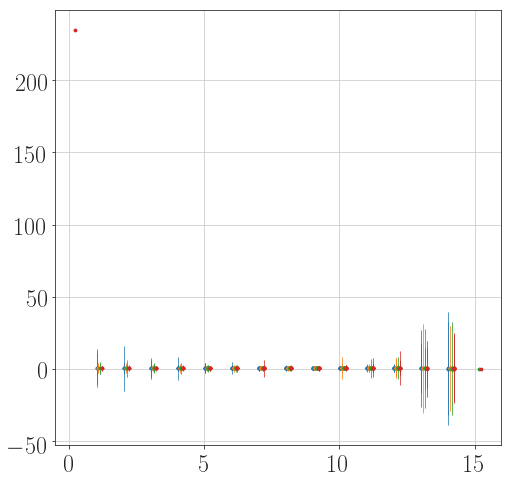

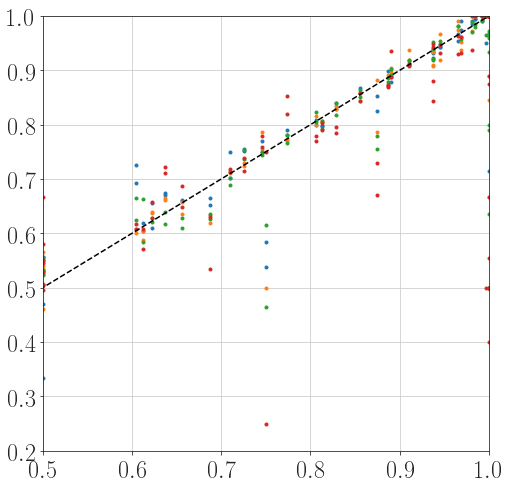

In [50]:
block_times=[150,50]
fig,ax=pl.subplots()
fig2,ax2=pl.subplots()
for i in range(1,3):
    for pit,post_interval in enumerate(block_times):
        dftmp=df_data[(df_data.idSubject==i) & (df_data.nPostInterval==post_interval)].reset_index()
        plot_dec_times(dftmp,pl,'monkey_pcorr_'+str(i)+'_post_'+str(post_interval),ymax=(i*2+pit-1.5)/1.5/10,ax=ax,ax2=ax2)
ax2.set_xlim(0.5,1.0)
ax2.set_ylim(0.2,1)
ax2.plot([0,1],[0,1],'k--')
# ax2.set_clip_on(False)
# T=15
# T=15
# for Nm in 2*np.arange(T):
#     ax.plot(np.arange(T+1-Nm/2)+Nm/2,[get_pt_plus(15,t,Nt) for t,Nt in zip(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2)],'-',ms=5,lw=0.5,color=[0.5]*3,mew=0.5,mfc='k',mec='k')
# for Np in 2*np.arange(T):
#     ax.plot(np.arange(T+1-Np/2)+Np/2,[1-get_pt_plus(15,t,Nt) for t,Nt in zip(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2)],'-',ms=5,lw=0.5,color=[0.5]*3,mew=0.5,mfc='k',mec='k')
# ax.set_ylim(0,1)
# ax.set_xlim(0,15)
# ax.set_ylabel(r'Accuracy, $p_{\textrm{corr}}(n,t)$')
# ax.set_xlabel(r'time (steps)')
# ax.grid('off')
# fig.savefig('acccuracy_grid.png', transparent=True,dpi=300)

In [8]:
def binomial(n, k):
    
    if 0 <= k <= n:
        ntok = 1
        ktok = 1
        for t in range(1, min(k, n - k) + 1):
            ntok *= n
            ktok *= t
            n -= 1
        return ntok // ktok
    else:
        return 0

In [9]:
def get_pt_plus(T,t,Nt,p=0.5):
    '''
    Outputs probability that state>=0 at time T if state is Nt at time t, for +ve jump probability, p.
    Behaves strangely for T a multiple of 10...
    '''
    if t==-1:
        return p
    else:
        tp=T - t #-1
        Nt_plus=(t+Nt)/2.
        if tp<(T-1)/2.-(t-Nt)/2.:
            if Nt>0:
                return 1
            else:
                return 0
        else:
            #Cisek;'s'
            NL=(t-Nt)/2.
            Nc=T-t
            kvec=np.arange(0,(np.min((Nc,(T-1)/2-NL))+1))
            return np.power(p,Nc)*np.sum(np.asarray([binomial(int(Nc), int(k)) for k in kvec]))

In [104]:
df_data.head()

,idSubject,nPostInterval,nChoiceMade,nCorrectChoice,tDecision,tFirstTokJump,nDecisionToken,nDProb,nDSLR,sTokenDirs,sTrialType,seq
0,1,50,-1,1,6.320,610.0,6.0,0.746090,0.84,112211212212212,null,"[-1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, ..."
1,1,50,1,-1,2.475,742.0,2.0,0.709470,0.84,221111112122121,null,"[1, 1, -1, -1, -1, -1, -1, -1, 1, -1, 1, 1, -1..."
2,1,50,-1,1,10.380,788.0,10.0,0.500000,0.00,112212212122121,null,"[-1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, ..."
3,1,50,1,1,4.325,744.0,4.0,0.725586,0.84,221222221222121,null,"[1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1]"
4,1,50,1,1,3.680,1011.0,3.0,0.806152,1.26,222112121212121,null,"[1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, ..."


In [12]:
df_data['Nt']=df_data.seq.apply(lambda x: np.insert(np.cumsum(x),0,0))
def dummy(row):
    return np.array([get_pt_plus(15,t,Nt) for t,Nt in enumerate(row)])
df_data['Pt_plus']=df_data.Nt.apply(lambda x: dummy(x))

In [ ]:
def dummy(row):
    return np.array([get_pt_plus(t,Nt) for t,Nt in enumerate(row)])
df_traj['Pt_plus']=df_traj.Nt.apply(lambda x: dummy(x))

In [13]:
df_data['pcorratDectime']=df_data.apply(lambda row:np.max([row.Pt_plus[int(row.tDecision)],1-row.Pt_plus[int(row.tDecision)]]),axis=1) 

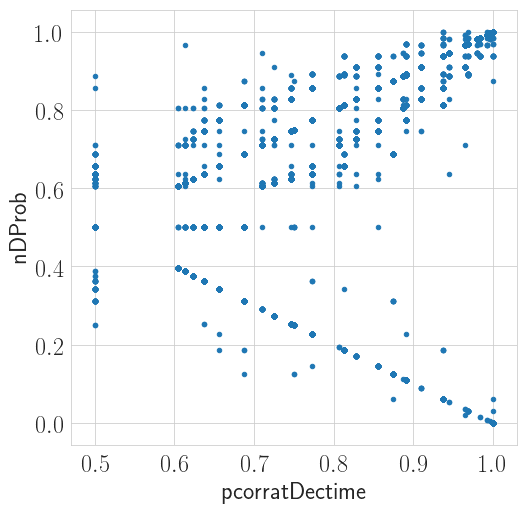

In [113]:
df_data.plot.scatter(x='pcorratDectime',y='nDProb')

tDecisionint
0     0.580952
1     0.705882
2     0.711434
3     0.771147
4     0.823165
5     0.831773
6     0.836485
7     0.828217
8     0.804397
9     0.764849
10    0.737476
11    0.713292
12    0.712811
13    0.600000
14    1.000000
Name: correct, dtype: float64
tDecisionint
0     0.674074
1     0.604651
2     0.696232
3     0.733748
4     0.754038
5     0.778085
6     0.789508
7     0.770694
8     0.744597
9     0.724440
10    0.719849
11    0.680460
12    0.673004
13    0.666667
Name: correct, dtype: float64
tDecisionint
0     0.516667
1     0.642127
2     0.680599
3     0.753981
4     0.778161
5     0.791135
6     0.798092
7     0.797067
8     0.785260
9     0.764230
10    0.749014
11    0.727392
12    0.687153
13    0.630435
Name: correct, dtype: float64
tDecisionint
0     0.588517
1     0.613455
2     0.669432
3     0.673525
4     0.724448
5     0.732805
6     0.764280
7     0.783085
8     0.791740
9     0.764073
10    0.713779
11    0.664905
12    0.660436
13    0.666667
Nam

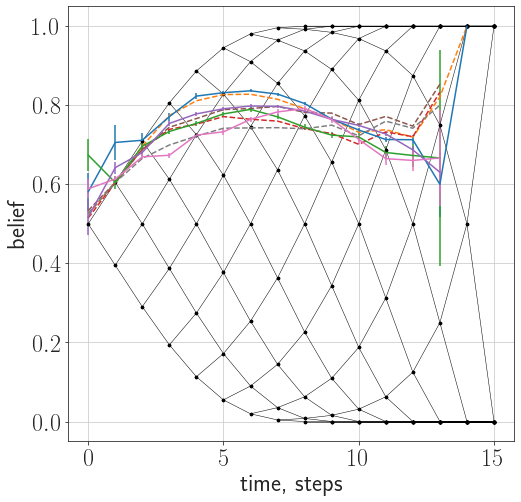

In [28]:
fig,ax=pl.subplots()
T=15
for Nm in 2*np.arange(T):
    ax.plot(np.arange(T+1-Nm/2)+Nm/2,[get_pt_plus(15,t,Nt) for t,Nt in zip(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
for Np in 2*np.arange(T):
    ax.plot(np.arange(T+1-Np/2)+Np/2,[1-get_pt_plus(15,t,Nt) for t,Nt in zip(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
gamvec=[3/4,1/4]
block_times=[150,50]
for i in range(1,3):
    for it,post_interval in enumerate(block_times):
        dftmp=df_data[(df_data.idSubject==i) & (df_data.nPostInterval==post_interval)].reset_index()
        dftmp['Nt']=dftmp.seq.apply(lambda x: np.insert(np.cumsum(x),0,0))
        dftmp['tDecisionint']=dftmp['tDecision'].astype('int')
        dftmp['tDecisionint']=dftmp['tDecisionint'].apply(lambda x: x if x>=0 else 0)  
        dftmp['correct']=(dftmp.nCorrectChoice==dftmp.nChoiceMade)
        bound=dftmp.groupby('tDecisionint')['correct'].mean()
        print(bound)
        bound_act=dftmp.groupby('tDecisionint')['pcorratDectime'].mean()
#         bound_act=dftmp.groupby('tDecisionint')['nDProb'].mean()
        bound_std=np.sqrt(bound*(1-bound)/dftmp.groupby('tDecisionint').size())
        ax.errorbar(range(len(bound)),bound,yerr=bound_std,label=r'$\alpha='+str(gamvec[it])+'$,M'+str(i))
        ax.plot(bound_act,'--')
        ax.set_ylabel('belief')
        ax.set_xlabel('time, steps')
#         fig.savefig('inferred_bounds.png', transparent=True,dpi=300)
#         np.save('data_bel_boundary_subj_'+str(i)+'_postint_'+str(post_interval)+'.npy',(np.asarray(bound.index.values,dtype=int),bound.values))
# ax.legend()


In [82]:
T=15

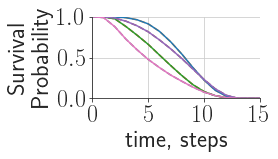

In [91]:
fig,ax=pl.subplots(figsize=(3,1.5))
# T=15
# for Nm in 2*np.arange(T):
#     ax.plot(np.arange(T+1-Nm/2)+Nm/2,[get_pt_plus(15,t,Nt) for t,Nt in zip(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
# for Np in 2*np.arange(T):
#     ax.plot(np.arange(T+1-Np/2)+Np/2,[1-get_pt_plus(15,t,Nt) for t,Nt in zip(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
gamvec=[3/4,1/4]
block_times=[150,50]
for i in range(1,3):
    for it,post_interval in enumerate(block_times):
        dftmp=df_data[(df_data.idSubject==i) & (df_data.nPostInterval==post_interval)].reset_index()
        dftmp['Nt']=dftmp.seq.apply(lambda x: np.insert(np.cumsum(x),0,0))
        dftmp['tDecisionint']=dftmp['tDecision'].astype('int')
        dftmp['tDecisionint']=dftmp['tDecisionint'].apply(lambda x: x if x>=0 else 0)  
        dftmp['correct']=(dftmp.nCorrectChoice==dftmp.nChoiceMade)
        
        #survival function
        bound=[]
        bound_std=[]
        for t in range(T+1):
            bval=dftmp.loc[dftmp.tDecisionint>=t].size /     (dftmp.size)      
            bound.append(bval)
            bound_std.append(np.sqrt(bval*(1-bval)/((dftmp.size))))
#         print(bound)
#         bound_act=dftmp.groupby('tDecisionint')['pcorratDectime'].mean()
#         bound_act=dftmp.groupby('tDecisionint')['nDProb'].mean()
#         bound_std=np.sqrt(bound*(1-bound)/dftmp.groupby('tDecisionint').size())
        ax.errorbar(range(len(bound)),bound,yerr=bound_std,label=r'$\alpha='+str(gamvec[it])+'$,M'+str(i))
        ax.plot(bound,'--')
        ax.set_ylabel('Survival \n Probability')
        ax.set_xlabel('time, steps')
        ax.set_xlim(0,15)
        ax.set_xticks([0,5,10,15])
        ax.set_yticks([0,0.5,1])
        ax.set_ylim(0,1)
        ax.grid(None)
        # Hide the right and top spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Only show ticks on the left and bottom spines
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
#         fig.savefig('inferred_bounds.png', transparent=True,dpi=300)
#         np.save('data_bel_boundary_subj_'+str(i)+'_postint_'+str(post_interval)+'.npy',(np.asarray(bound.index.values,dtype=int),bound.values))
# ax.legend()


18 decisions before t=0!
66897.0


/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in double_scalars
/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in double_scalars


<IPython.core.display.Javascript object>


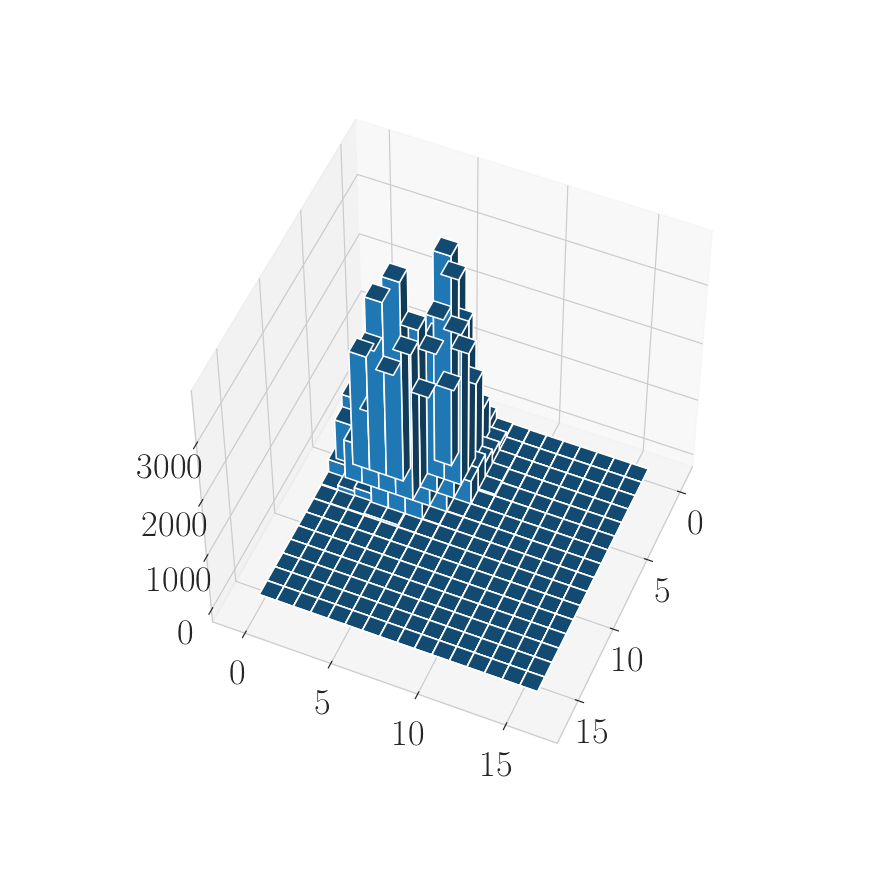

23 decisions before t=0!
36274.0


<IPython.core.display.Javascript object>


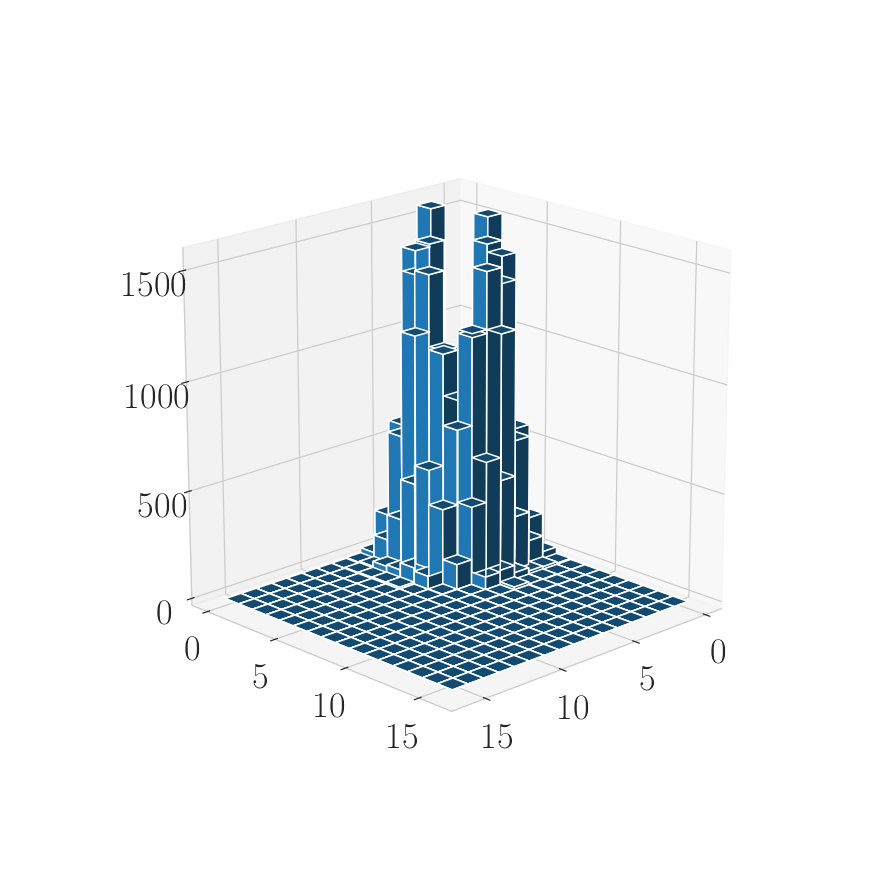

39 decisions before t=0!
66654.0


<IPython.core.display.Javascript object>


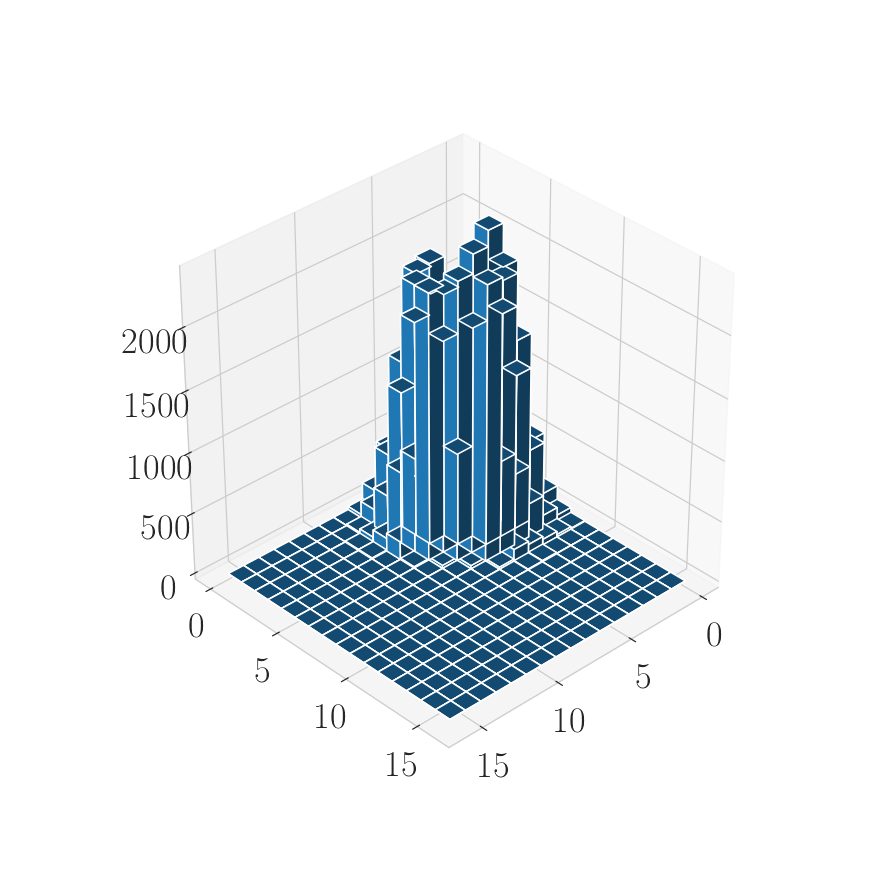

1 decisions at t=0!
101 decisions before t=0!
39408.0


<IPython.core.display.Javascript object>


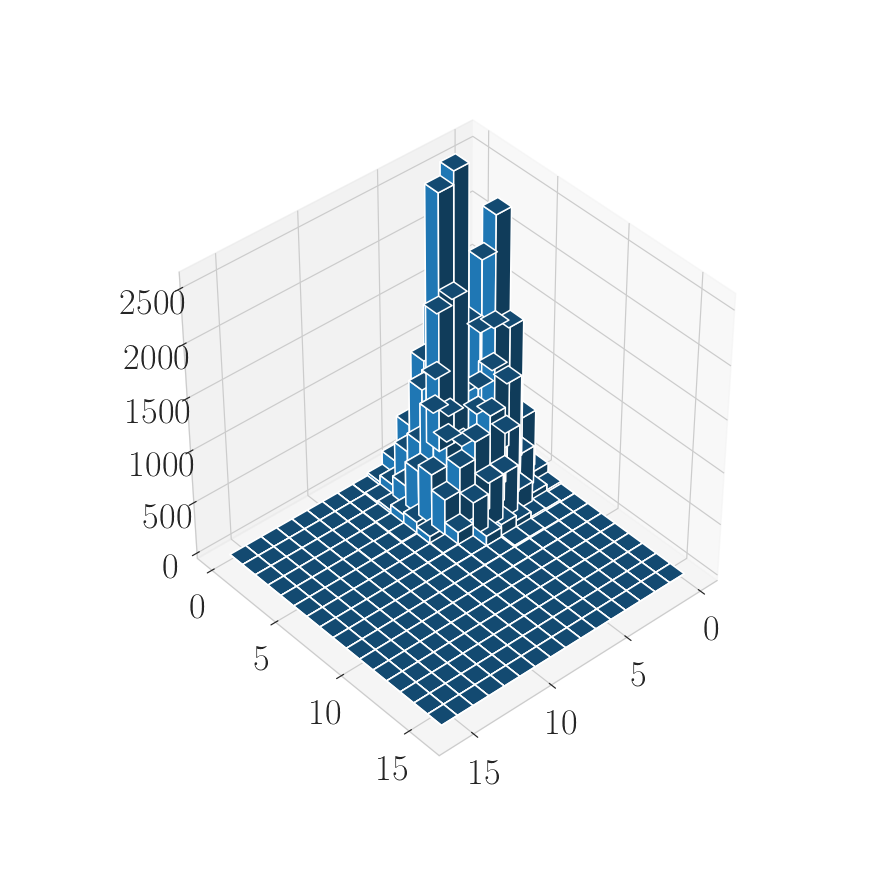

In [11]:
block_times=[150,50]
for i in range(1,3):
    for post_interval in block_times:
#         print((df_data[(df_data.idSubject==i) & (df_data.nPostInterval==post_interval)].tDecision==0).sum())
        plot_dec_times(df_data[(df_data.idSubject==i) & (df_data.nPostInterval==post_interval)].reset_index(),pl,'monkey_'+str(i)+'_post_'+str(post_interval),ymax=0.2)

Look at speed accuracy

In [ ]:
#code here: compute accuracy plot, i.e. the correct fraction as a function of (n,t) state, then plot speed accuracy curve: T/tdec vs. accuracy at (ndec,tdec), for each of (monkey 1/2,fast/slow block) pair

#fit parameter b. determine functions for b and gamma. 

#try different priors to get different discounting to better match data

Plot occupancy

In [73]:
T=15
occupancy_map=np.zeros((2*T+1,T))
for t,Nt_samples in enumerate(np.cumsum(np.asarray(df_data.seq.tolist()),axis=1).T):
    counts,bins=np.histogram(Nt_samples,bins=np.arange(-T,T+2))
    occupancy_map[:,t]=counts#/np.sum(counts)

C:\Users\mptouzel\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


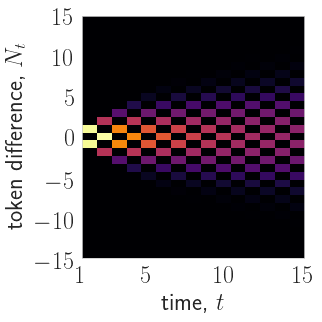

In [82]:
fig,ax=pl.subplots(figsize=(5,5))
C=ax.imshow(occupancy_map,aspect='auto',cmap='inferno',origin='lower',extent=[0,14,-15,15])
ax.set_xticks([0,4,9,14])
ax.set_xticklabels(['$1$','$5$','$10$','$15$'])
ax.set_yticks([-15,-10,-5,0,5,10,15])
ax.set_xlabel(r'time, $t$')
ax.set_ylabel('token difference, $N_t$')
# cbar = ax.figure.colorbar(C)
# cbar.set_label('\# samples')
fig.tight_layout()
ax.grid('off')
fig.savefig('occupancy.png', transparent=True,dpi=300)

Get state at decision times

In [154]:
Nt_state_at_dec=np.zeros(len(df_data))
for it,tdec in enumerate(df_data.tDecision.values):
    curr_traj=df_data.seq.iloc[it]
    Nt_state_at_dec[it]=np.sum(curr_traj[:int(tdec)]) if tdec>0 else 0
        
print(max(Nt_state_at_dec))

9.0


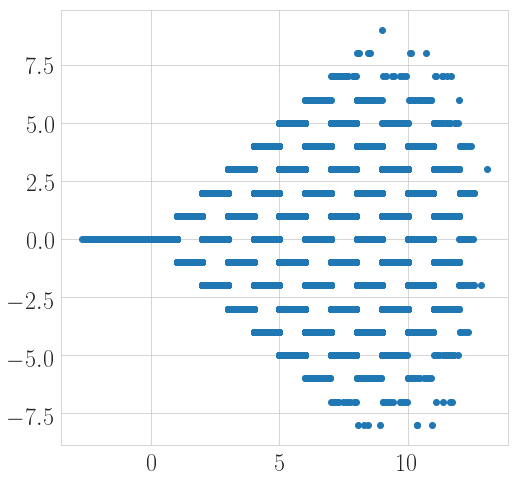

In [157]:
fig,ax=pl.subplots(1,1)
ax.scatter(df_data.tDecision.values,Nt_state_at_dec)
# ax.set_yticks(range(-8,9))

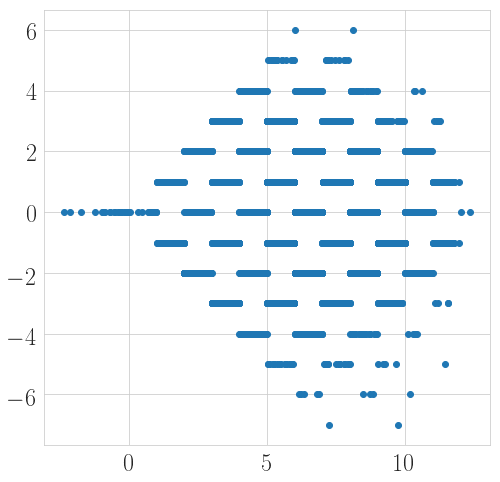

In [156]:
#without pinning decsion time to token jump times:
fig,ax=pl.subplots(1,1)
ax.scatter(df_data[:10000].tDecision.values,Nt_state_at_dec[:10000])
# ax.set_yticks(range(-8,9))
# ax.hist2d(tdecarr/200.,Nt_state_at_dec, bins=[np.linspace(0,15,50),np.linspace(-15,15,50)], cmap=pl.cm.jet);

#could be more clearly plotted as a line density for each each Nt, in a 3D plot viewed at (45,45,45)

no density information. Easier to see in (Np,Nm) coordinates (neglect variability within state, since model only dependent on state).

biuld (Np,Nm) coordinate frame

In [333]:
dist=np.zeros((15,15))
dist_R=np.zeros((15,15))
dist_L=np.zeros((15,15))
dist_wait=np.zeros((15,15))

# Nt_state_at_dec=np.zeros(len(tdecarr))
# Nt_state_at_dec_R=np.zeros(len(tdecarr))
# Nt_state_at_dec_L=np.zeros(len(tdecarr))
for it,tdec in enumerate(df_data.tDecision.values):
    curr_traj=df_data.seq.iloc[it]
    dist[np.sum(curr_traj[:int(tdec)]==1),np.sum(curr_traj[:int(tdec)]==-1)]+=1 #increment occupancy at given (Np,Nm)
    if df_data.nChoiceMade.iloc[it]==1:
        dist_R[np.sum(curr_traj[:int(tdec)]==1),np.sum(curr_traj[:int(tdec)]==-1)]+=1 #increment occupancy at given (Np,Nm)
    else:# trial_dec[it]==-1:
        dist_L[np.sum(curr_traj[:int(tdec)]==1),np.sum(curr_traj[:int(tdec)]==-1)]+=1 #increment occupancy at given (Np,Nm)
    for sit in range(int(tdec)):
        dist_wait[np.sum(curr_traj[:sit+1]==1),np.sum(curr_traj[:sit+1]==-1)]+=1 #increment occupancy at given (Np,Nm)

occupancy_dist=np.zeros((15,15))
occupancy_dist_R=np.zeros((15,15))
occupancy_dist_L=np.zeros((15,15))

In [334]:
Nt_samples=np.cumsum(np.asarray(df_data.seq.tolist()),axis=1)
for Np in np.arange(15):
    for Nm in np.arange(15):
        if Np+Nm<15 and Np+Nm>0:
            occupancy_dist[Np,Nm]=np.sum(Nt_samples[:,Np+Nm-1]==Np-Nm)     #-1 since time to time index: t_ind=t-1
            occupancy_dist_R[Np,Nm]=np.sum(Nt_samples[df_data.nChoiceMade.values==1,Np+Nm-1]==Np-Nm)     #-1 since time to time index: t_ind=t-1
            occupancy_dist_L[Np,Nm]=np.sum(Nt_samples[df_data.nChoiceMade.values==-1,Np+Nm-1]==Np-Nm)     #-1 since time to time index: t_ind=t-1

plot decision times

[]

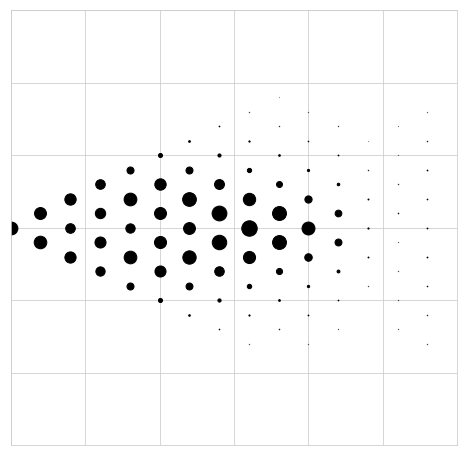

In [18]:
fig,ax=pl.subplots(1,1,frameon=False)
for Np in range(15):
    for Nm in range(15):
        ax.scatter(Np+Nm,Np-Nm,s=5e3*dist[Np,Nm]/np.sum(dist),color='k')
ax.set_xlim(0,15)
ax.set_ylim(-15,15)
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.axis('off')
# pl.savefig('tdec_exp.png', transparent=True)

But this is over trials. Plot instead over state:

[]

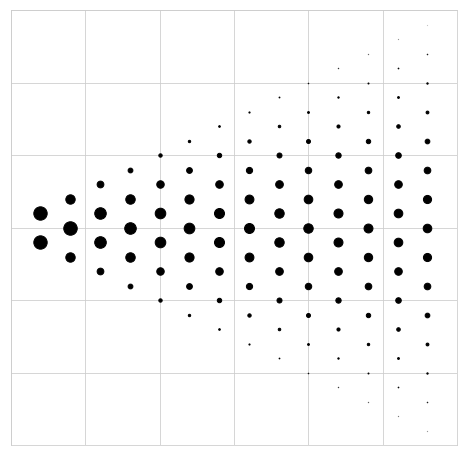

In [19]:
fig,ax=pl.subplots(1,1,frameon=False)
for Np in range(15):
    for Nm in range(15):
        ax.scatter(Np+Nm,Np-Nm,s=5e3*occupancy_dist[Np,Nm]/np.sum(occupancy_dist),color='k')
ax.set_xlim(0,15)
ax.set_ylim(-15,15)
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.axis('off')

So, normalize time counts with occupancy:

[]

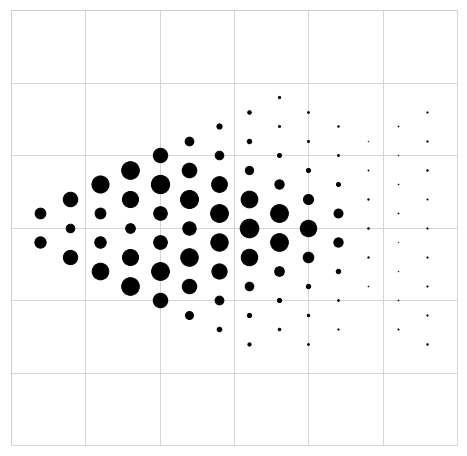

In [20]:
fig,ax=pl.subplots(1,1,frameon=False)
for Np in range(15):
    for Nm in range(15):
        if dist[Np,Nm]< occupancy_dist[Np,Nm]:
            ax.scatter(Np+Nm,Np-Nm,s=2e3*dist[Np,Nm]/occupancy_dist[Np,Nm],color='k')
ax.set_xlim(0,15)
ax.set_ylim(-15,15)
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.axis('off')

Do as density

In [335]:
dist_tmp=np.zeros(dist.shape)
dist_R_tmp=np.zeros(dist_R.shape)
dist_L_tmp=np.zeros(dist_L.shape)
dist_wait_tmp=np.zeros(dist_L.shape)

for Np in range(15):
    for Nm in range(15):
        if dist[Np,Nm] < occupancy_dist[Np,Nm]:
            dist_tmp[Np,Nm]=dist[Np,Nm]/occupancy_dist[Np,Nm]
        if dist_R[Np,Nm] < occupancy_dist[Np,Nm]:
            dist_R_tmp[Np,Nm]=dist_R[Np,Nm]/occupancy_dist[Np,Nm]
        if dist_L[Np,Nm] < occupancy_dist[Np,Nm]:
            dist_L_tmp[Np,Nm]=dist_L[Np,Nm]/occupancy_dist[Np,Nm]
        if dist_wait[Np,Nm] < occupancy_dist[Np,Nm]:
            dist_wait_tmp[Np,Nm]=dist_wait[Np,Nm]/occupancy_dist[Np,Nm]

C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


Text(0.5, 1.0, 'commitment time distribution')

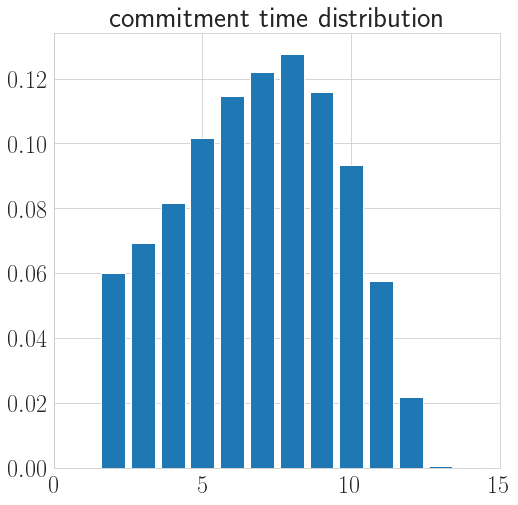

In [337]:
t_dist=np.zeros((T,))
for t in range(T):
    Nt_occu=np.diagonal(np.flipud(occupancy_dist),offset=-T+t).sum()
    Nt_dec=np.diagonal(np.flipud(dist),offset=-T+t).sum()
    t_dist[t]=Nt_dec/Nt_occu#np.diagonal(np.flipud(dist_tmp),offset=-T+t).mean()
fig,ax=pl.subplots(1,1)
ax.bar(range(T),t_dist)
ax.set_xlim(0,T)
ax.set_xticks([0,5,10,15])
ax.set_title('commitment time distribution')

In [23]:
#normalize over sample paths
dist=dist_tmp
dist_R=dist_R_tmp
dist_L=dist_L_tmp
dist_wait=dist_wait_tmp

In [24]:
mesh=np.meshgrid(range(15),range(15))
Npvec=mesh[0].flatten()
Nmvec=mesh[1].flatten()
tvec=Npvec+Nmvec
Nvec=Npvec-Nmvec

tvecdense=np.linspace(min(tvec),max(tvec),100)
Nvecdense=np.linspace(min(Nvec),max(Nvec),100)
z=griddata((tvec,Nvec),dist.flatten()/np.sum(np.sum(dist)), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')
z_R=griddata((tvec,Nvec),dist_R.flatten()/np.sum(np.sum(dist_R)), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')
z_L=griddata((tvec,Nvec),dist_L.flatten()/np.sum(np.sum(dist_L)), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')
# z_wait=griddata((tvec,Nvec),(1-dist_L-dist_R).flatten()/np.sum(np.sum(1-dist_L-dist_R)), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')
z_wait=griddata((tvec,Nvec),dist_wait.flatten()/np.sum(np.sum(dist_wait)), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')

In [25]:
#get maximums for a fixed time
# fig,ax=pl.subplots(1,1)
# maxplus=np.zeros((len(np.arange(1,99,7)),))
# for itt,it in enumerate(np.arange(1,99,7)):
#     p=ax.plot(z[:50,it][::-1])
#     ax.plot(z[50:,it],color=p[-1].get_color(),label=str(it))
#     maxind=np.nanargmax(z[50:,it])
#     ax.scatter(maxind,z[50+maxind,it],marker='o',s=100,cmap=p[-1].get_color())
#     maxplus[itt]=maxind/100
# ax.legend(frameon=False)

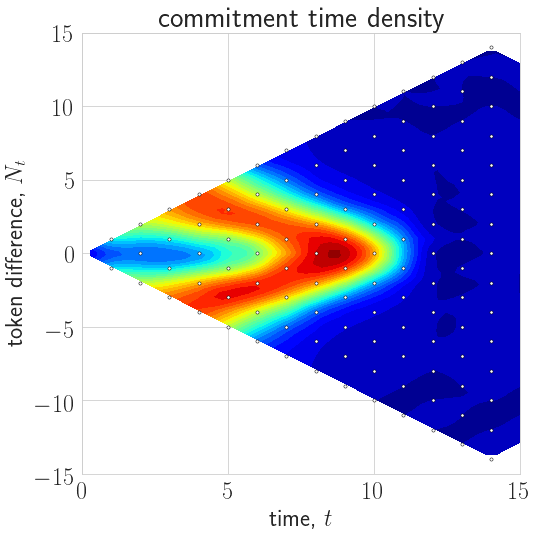

In [26]:
fig,ax=pl.subplots(1,1,frameon=False)

# CS=ax.contour(tvecdense,Nvecdense,z,19,linewidth=0.5,colors='k')
CS=ax.contourf(tvecdense,Nvecdense,z,30,cmap=pl.cm.jet)
# ax.plot(np.arange(1,99,7)/3,maxplus*30,'w--',linewidth=3)
# ax.plot(np.arange(1,99,7)/3,-maxplus*30,'w--',linewidth=3)

# maxtime=4.4
# Nm=np.linspace(0,maxtime)
# Np=maxtime
# ax.plot(Nm+Np,Np-Nm,'w--',linewidth=3)
# Np=np.linspace(0,maxtime)
# Nm=maxtime
# ax.plot(Nm+Np,Np-Nm,'w--',linewidth=3)
# maxtime=8
# Nm=np.linspace(0,maxtime)
# Np=maxtime
# ax.plot(Nm+Np,Np-Nm,'w--',linewidth=3)
# Np=np.linspace(0,maxtime)
# Nm=maxtime
# ax.plot(Nm+Np,Np-Nm,'w--',linewidth=3)

# pl.colorbar(CS)
ax.set_xlim(0,15)
ax.set_ylim(-15,15)
ax.set_xticks([0,5,10,15])
# ax.set_yticklabels([])
# ax.axis('off')
# ax.set_ylabel(r'$N_t=N^+_t-N^-_t$')
ax.set_title('commitment time density')
for Np in range(15):
    for Nm in range(15):
        if dist[Np,Nm]< occupancy_dist[Np,Nm]:
            ax.scatter(Np+Nm,Np-Nm,s=10,facecolor='w',edgecolor='k',lw=0.5)
ax.set_xlabel(r'time, $t$')
ax.set_ylabel('token difference, $N_t$')
fig.tight_layout()
# cbar = ax.figure.colorbar(CS)
# cbar.set_label('\# samples')
pl.savefig('monkey_choices_actual.png', transparent=True,dpi=300,bbox_inches='tight')

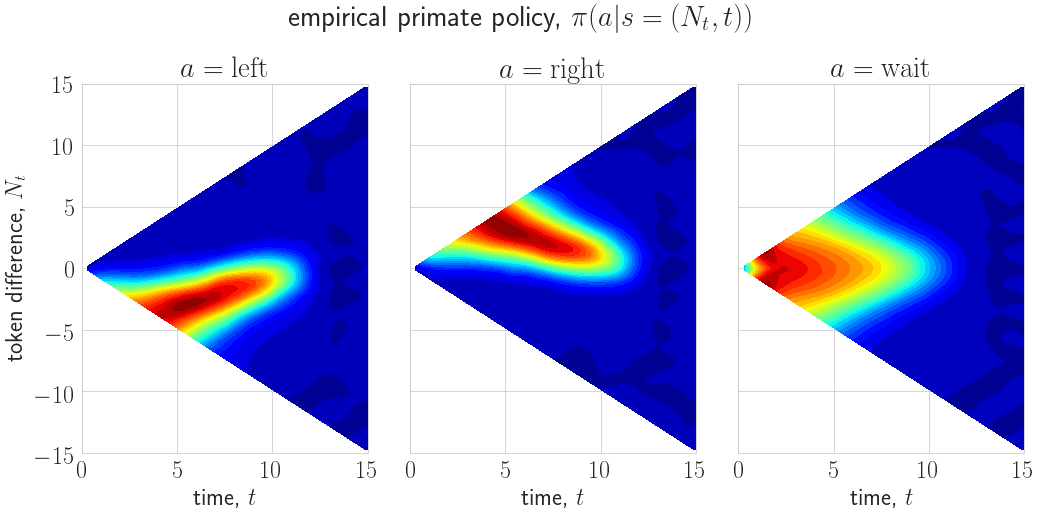

In [74]:
fig,ax=pl.subplots(1,3,frameon=False,figsize=(15,7))
strp=['left','right','wait']
zvec=[z_R,z_L,z_wait] #wrong order here, because something above is in wrong order...
for p in range(3):
    CS=ax[p].contourf(tvecdense,Nvecdense,zvec[p],30,cmap=pl.cm.jet)
    if p==0:
        ax[p].set_ylabel(r'token difference, $N_t$')
    else:
        ax[p].set_yticklabels('')
    ax[p].set_xlim(0,15)
    ax[p].set_ylim(-15,15)
    ax[p].set_xticks([0,5,10,15])
    ax[p].set_xlabel(r'time, $t$')
    ax[p].set_title(r'$a=\textrm{'+strp[p]+'}$')
fig.tight_layout()
fig.suptitle(r'empirical primate policy, $\pi(a|s=(N_t,t))$',y=1.05)
fig.savefig('primate_policy.png', transparent=True,bbox_inches="tight",dpi=300)